# 信贷申请评分卡_A卡案例

主要项目流程：数据获取、数据清洗(特征初筛)、特征工程、模型建立与评价等

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

C:\Users\15742\Anaconda35\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [35]:
# % config ZMQInteractiveShell.ast_node_interactivity='all'

# 1.数据获取

In [3]:
# 数据基本描述：信贷申请数据--42535个样本，144个特征

In [4]:
data = pd.read_excel('LoanStats_2018Q3.xlsx')
data.shape

(42535, 144)

In [5]:
# 特征列表
feature_list = list(data)
print(feature_list)
df = data.copy()
df.head()

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,2,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,3,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,4,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,5,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


# 2.数据清洗（特征初筛）

In [37]:
# 2.1 申请评分卡使用的数据不能是借款人借款后的信息，需删除18个特征
del_feature_list = ['sub_grade','grade','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
                    'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                    'last_pymnt_amnt','last_credit_pull_d','collections_12_mths_ex_med','policy_code','disbursement_method']
print(df.shape)
df_01 = df.copy().drop(columns=del_feature_list, axis=1)
print(df_01.shape)

(42535, 144)
(42535, 126)


In [7]:
# 2.2 删除客户隐私的字段:['emp_title','title']
customer_info = ['emp_title','title']
df_02 = df_01.drop(columns=customer_info, axis=1)
df_02.shape

(42535, 124)

In [8]:
# 2.3 去重，删除空行
df_03 = df_02.drop_duplicates('id').dropna(axis=0, how='all')
df_03.shape

(42535, 124)

In [9]:
# 2.4 删除缺失率大于0.95的字段
# is_null = [df_03[i_feature].isnull().sum() for i_feature in list(df_03)]
cols_null = []
for col_null in df_03.columns:
    if df_03[col_null].isnull().sum() > (df_03.shape[0])*0.95:
        cols_null.append(col_null)
print(len(cols_null))
df_04 = df_03.drop(cols_null, axis=1)
df_04.shape

86


(42535, 38)

In [10]:
# 例：唯一值
# 2.5 判断每个特征值的分布，若存在某一个值占比超过95%，则删除(分箱前提)
col_handle = []
for col_ in df_04.columns:
    if df_04[col_].value_counts().max() > df_04.shape[0]*0.95:
        col_handle.append(col_)
print(col_handle)
df_05 = df_04.drop(col_handle, axis=1)
df_05.shape

['pymnt_plan', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


(42535, 30)

In [11]:
# 2.6 删除id号
df_06 = df_05.drop('id', axis=1)
df_06.shape

(42535, 29)

In [12]:
# 2.7 查看借款期限，并选出借款36期的样本
print(df_06['term'].value_counts())
df_06['term'] = df_06['term'].replace(' 36 months', 36).replace(' 60 months', 60)
df_final = df_06[df_06['term']==36]
df_final.shape

 36 months    31534
 60 months    11001
Name: term, dtype: int64


(31534, 29)

In [13]:
# 2.8 数据类型查看与转换
def obj_feature(df_final):
    obj_feature = []
    for obj_f in df_final.columns:
        if df_final[obj_f].dtypes == 'object':
            obj_feature.append(obj_f)
    print(obj_feature)
    return obj_feature

obj_feature = obj_feature(df_final)

['emp_length', 'home_ownership', 'verification_status', 'loan_status', 'desc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'total_acc']


In [38]:
# 特征值查看
# 1) emp_length--工作年限
df_finals = df_final.copy()
# print(df_finals['emp_length'].value_counts())
print(df_finals['emp_length'].unique())

def emp_length_new(x):
    if x=='< 1 year':
        return 0
    elif x=='1 year':
        return 1
    elif x=='10+ years':
        return 11
    elif str(x)=='nan':
        return np.nan
    else:
        return x.replace(' years', '')
    
df_finals['emp_length'] =df_finals['emp_length'].map(lambda x: emp_length_new(x))
df_finals['emp_length'].unique()
df_finals['emp_length'] = df_finals['emp_length'].apply(pd.to_numeric, errors='coerce')
# print('===================================')

# 2) home_ownership--房产权:类别型特征
# print(df_finals['home_ownership'].value_counts())
# print('===================================')

# 3) verification_status--验证状态:类别型特征
# print(df_finals['verification_status'].value_counts())
# print('===================================')

# 4) loan_status--贷款状态:y
# df_finals['loan_status'].value_counts()
df_finals['loan_status'] = df_finals['loan_status'].copy().map(lambda x: 1 if 'Charged Off' in x else 0)
# print(df_finals['loan_status'].value_counts())
# print('===================================')

# 5) desc--自然语言模块，暂不考虑
df_finals = df_finals.drop('desc', axis=1)
# print('===================================')

# 6) purpose--用途：类别型特征
# print(df_finals['purpose'].value_counts())
# print('===================================')

# 7) zip_code--邮政编码
df_finals = df_finals.drop('zip_code', axis=1)
# print('===================================')

# 8) addr_state--地址状态：类别型特征
# print(df_finals['addr_state'].value_counts())
# print('===================================')

# 9) delinq_2yrs：过去两年逾期次数
# print(df_finals['delinq_2yrs'].value_counts())
set(df_finals['delinq_2yrs'])
df_finals['delinq_2yrs'] = df_finals['delinq_2yrs'].apply(pd.to_numeric, errors='coerce')

# 10) total_acc
set(df_finals['total_acc'])
df_finals['total_acc'] = df_finals['total_acc'].apply(pd.to_numeric, errors='coerce')

['10+ years' '3 years' '9 years' '< 1 year' '4 years' '1 year' '6 years'
 '5 years' '2 years' '7 years' '8 years' nan]


array([11, '3', '9', 0, '4', 1, '6', '5', '2', '7', '8', nan],
      dtype=object)

{0,
 1,
 11,
 13,
 datetime.datetime(1997, 1, 1, 0, 0),
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 nan}

{1,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 2,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 3,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 4,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 5,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 6,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 7,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 79,
 8,
 80,
 9,
 90,
 'f',
 nan}

In [15]:
# 2.9 特征衍生：loan_amnt贷款额度，annual_inc年收入（贷款收入比）
# df_finals[['loan_amnt','annual_inc', 'issue_d', 'earliest_cr_line', 'next_pymnt_d']]
df_finals['pnt_loan_annual'] = df_finals.loan_amnt/df_finals.annual_inc
print(df_finals.shape)
df_finals.columns

(31534, 28)


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'next_pymnt_d', 'pub_rec_bankruptcies', 'pnt_loan_annual'],
      dtype='object')

In [16]:
# 特征列表分类
# 离散(类别型)特征:home_ownership, verification_status, purpose, addr_state
char_feature = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']

# 日期型特征：issue_d，earliest_cr_line，next_pymnt_d
time_feature = ['issue_d', 'earliest_cr_line', 'next_pymnt_d']
df_finals[time_feature] = df_finals[time_feature].apply(pd.to_datetime)

# 标签
df_label=['loan_status']

# 连续型特征
num_feature = df_finals.copy().columns.drop(time_feature).drop(char_feature).drop(df_label)
for i_f in num_feature:
    df_finals[i_f] = df_finals[i_f].apply(pd.to_numeric, errors='coerce')
print(len(num_feature))

19


In [17]:
# *数据探索
# 类别型(离散)特征: 每个特征值分布概率值
def data_distributed(df_finals, char_feature):
    rate_feature_all = []
    for col in char_feature:
        result = df_finals[col].value_counts()
        #print('char_feature_name:', col)
        rate_feature = []
        for v_i in range(len(result)):
            rate = result[v_i]/result.sum()
            rate_feature.append(rate)
        rate_feature = pd.Series(rate_feature).to_frame().reset_index().rename(columns={'index':'id', 0: 'rate'})
        result = pd.Series(result).to_frame().reset_index().reset_index().rename(columns={'level_0':'id', 'index':'f_name',
                                                                                          'home_ownership':'value_count'})
        rate_feature = pd.merge(result, rate_feature, on=['id']).drop('id', axis=1)
        rate_feature_all.append(rate_feature)
    return rate_feature_all

df_finals['emp_length'] = df_finals['emp_length'].astype('str')
# df_finals['emp_length'].dtypes
rate_feature_all = data_distributed(df_finals, char_feature)
# rate_feature_all

In [18]:
# 2.10 缺失值查看与处理
# 离散特征
print(df_finals[char_feature].isnull().sum())
print('==============next=============')

# 连续型特征
print(df_finals[num_feature].isnull().sum())
# 缺失值处理：-999填充
df_s = df_finals.fillna(-999)

emp_length             0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
dtype: int64
==============next=============
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
annual_inc                    4
dti                           0
delinq_2yrs                  30
inq_last_6mths               29
mths_since_last_delinq    19747
mths_since_last_record    28530
open_acc                     29
pub_rec                      29
revol_bal                     0
revol_util                   86
total_acc                    30
pub_rec_bankruptcies       1365
pnt_loan_annual               4
dtype: int64


In [19]:
# 重命名与定义y标签：贷款状态(好样本0，坏样本1)
df_s=df_s.rename(columns={'loan_status':'y'})
df_s['y'].value_counts()

0    27658
1     3876
Name: y, dtype: int64

# 3.特征工程

In [20]:
# 根据iv值、相关性、多重共线性等筛选特征

In [21]:
# 离散：计算每个特征的iv值
def cal_charf_iv(char_df, label):
#     print(char_df.shape, '\n====计算离散特征的iv值====')
    all_feature_iv = []
    char_feature_name = []
    for char_f in list(char_df):
        if char_f not in label:
            char_feature_name.append(char_f)
            #print('feature:', char_f)
            df = pd.concat([char_df[char_f], char_df[label]], axis=1)
            #print(df.shape)
            # 好样本统计
            good_df = df[df[label]==0]
            good_count = good_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'good_count'})
            # 坏样本统计
            bad_df = df[df[label]==1]
            bad_count = bad_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'bad_count'})
            # 整合
            result_df = pd.merge(good_count, bad_count, on=['char_value'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum() # 好客户的占比
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum() # 坏客户的占比
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 4)
            # 计算woe(优势比):ln(好客户的占比/坏客户的占比)*100%
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            #print('feature_iv:',feature_iv)
            #print(str(char_f + ':'), feature_iv)
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(char_feature_name).to_frame().rename(columns={0:'feature_name'})
    feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return feature_name_iv

# 连续型：计算每个特征的iv值
def cal_numf_iv(num_df, label):
#     print(num_df.shape, '\n=========计算连续特征的iv值=========')
    all_feature_iv = []
    num_feature_name = []
#     print(list(num_df))
    for num_f in list(num_df):
        if num_f not in label:
            #print(num_f)
            num_feature_name.append(num_f)
            # 分箱操作--等频：10等份
            df_bin = pd.qcut(df_s[num_f], 10, duplicates='drop')
            df_bin_label = pd.concat([df_bin, df_s[label]], axis=1)
            # 好样本统计
            good_bin_df = df_bin_label[df_bin_label[label]==0].rename(columns={num_f:'bin'})
            good_count = good_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                    'bin':'good_count'}).sort_values(by='bin')
            # 坏样本统计
            bad_bin_df = df_bin_label[df_bin_label[label]==1].rename(columns={num_f:'bin'})
            bad_count = bad_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                  'bin':'bad_count'}).sort_values(by='bin')
            # 合并统计结果
            result_df = pd.merge(good_count, bad_count, on=['bin'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum()
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum()
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 6)
            # 计算iv值
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(num_feature_name).to_frame().rename(columns={0:'feature_name'})
    num_feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return num_feature_name_iv

def get_result_iv(feature_name_iv, low_th, high_th):
    # 特征iv值：评价指标
    #    a.iv<0.02, 预测效果：无明显；
    #    b.0.02=<iv<0.1, 预测效果：弱； 
    #    c.0.1=<iv<0.3, 预测效果：中等；
    #    d.0.3=<iv<0.5, 预测效果：强；
    #    e.0.5=<iv, 预测效果：需考虑；
    len_f = feature_name_iv.shape[0]
    threshold_high = feature_name_iv[feature_name_iv.feature_iv<high_th].shape[0]
    threshold_low = feature_name_iv[feature_name_iv.feature_iv>=low_th].shape[0]
    if threshold_high==len_f and threshold_low==len_f:
        print('all feature...')
    else:
        print('some feature...')
    # 选取iv值在固定范围的特征,若整体iv值不高，可稍微适当调整
    feature_sel = feature_name_iv[feature_name_iv.feature_iv>=low_th]
    feature_sels = feature_sel[feature_sel.feature_iv<high_th]
    return feature_sels

# 根据相关性、iv值，综合考虑特征
def del_feature_sub(sn_df, numf_vi, th_c):
    del_feature_sub = []
    for i in range(sn_df.shape[1]):
        for j in range(sn_df.shape[1]):
            if i==j:
                continue
            else:
                if sn_df.iloc[i][j]>=th_c:
                    numf_vi_i = numf_vi.iloc[i, 1]
                    numf_vi_j = numf_vi.iloc[j, 1]
                    if numf_vi_i>=numf_vi_j:
                        del_feature_sub.append(numf_vi.iloc[j, 0])
    del_feature_subs = list(set(del_feature_sub)) # 可删除特征字段
    return del_feature_subs

In [22]:
# 柱状图
def plot_histogram(df):
    all_feature_iv_list = list(df.feature_name)
    all_feature_iv_df = df.feature_iv
    plt.bar(range(len(all_feature_iv_list)), all_feature_iv_df, color='rgby')
    plt.show()
    
# 热力图
def plot_seaborn(df):
    plt.figure(figsize=(12, 8))
    sn.heatmap(df, annot=True)
    plt.title("The feature's heatmap")
    plt.show()

In [23]:
# 3.1 根据iv值筛选特征
# 1)离散(类别型)特征
char_df = pd.concat([df_s[char_feature], df_s['y']], axis=1)
feature_name_iv = cal_charf_iv(char_df, label='y')
feature_name_iv

# 2) 连续性特征
num_features = num_feature.copy().drop('term')
num_df = df_s[num_features]
num_df.shape
num_feature_name_iv = cal_numf_iv(num_df, label='y')
num_feature_name_iv

# 3)合并离散和连续的特征iv值
all_feature_iv = pd.concat([feature_name_iv, num_feature_name_iv],axis=0).reset_index().drop('index', axis=1)
all_feature_iv
 
# 4) 特征筛选_取iv值范围：[0.01, 0.5)
feature_sels_vi = get_result_iv(all_feature_iv, low_th=0.01, high_th=0.5)
sel_feature_ = list(feature_sels_vi.feature_name)  # 筛选后的特征列表：sel_feature_
print('特征总个数:', all_feature_iv.shape[0])
print('根据iv筛选后的剩余特征个数:',len(sel_feature_))
feature_sels_vi

,feature_name,feature_iv
0,emp_length,0.013553
1,home_ownership,0.009319
2,verification_status,0.008974
3,purpose,0.089033
4,addr_state,0.049407


(31534, 18)

,feature_name,feature_iv
0,loan_amnt,0.015097
1,funded_amnt,0.016292
2,funded_amnt_inv,0.061025
3,int_rate,0.272160
4,installment,0.010712
5,annual_inc,0.060682
6,dti,0.013676
7,delinq_2yrs,0.006706
8,inq_last_6mths,0.131574
9,mths_since_last_delinq,0.004958


,feature_name,feature_iv
0,emp_length,0.013553
1,home_ownership,0.009319
2,verification_status,0.008974
3,purpose,0.089033
4,addr_state,0.049407
5,loan_amnt,0.015097
6,funded_amnt,0.016292
7,funded_amnt_inv,0.061025
8,int_rate,0.272160
9,installment,0.010712


some feature...
特征总个数: 23
根据iv筛选后的剩余特征个数: 17


,feature_name,feature_iv
0,emp_length,0.013553
3,purpose,0.089033
4,addr_state,0.049407
5,loan_amnt,0.015097
6,funded_amnt,0.016292
7,funded_amnt_inv,0.061025
8,int_rate,0.272160
9,installment,0.010712
10,annual_inc,0.060682
11,dti,0.013676


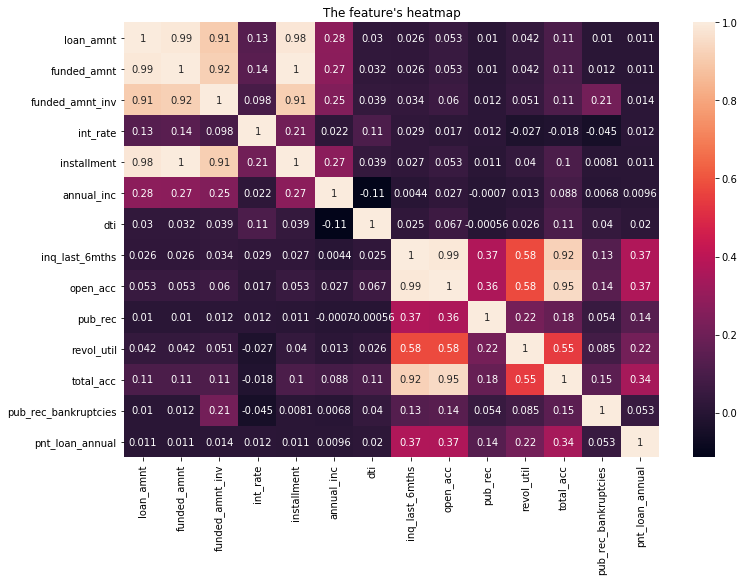

删除特征字段： 5 
 ['loan_amnt', 'open_acc', 'installment', 'funded_amnt', 'total_acc']
原特征字段： 14 
 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的特征字段： 9 
 ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的所有特征字段： 12 
 ['emp_length', 'purpose', 'addr_state', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']


In [24]:
# 3.2 根据相关性与iv筛选特征(连续性特征)
# 注：相关性高的两个特征(阈值0.7)，可删除iv值较小的特征
# 相关性分析：连续性特征(14个)
sub_num_feature = list(df_s[sel_feature_])[3:]
sub_char_feature = list(df_s[sel_feature_])[0:3]
sn_df = df_s[sub_num_feature].corr()
# 热力图
plot_seaborn(sn_df)
numf_vi = feature_sels_vi[3:].reset_index().drop('index', axis=1)

# 可删除特征字段
del_feature_subs = del_feature_sub(sn_df, numf_vi, th_c=0.7)
print('删除特征字段：', len(del_feature_subs), '\n', del_feature_subs)
print('原特征字段：', len(sub_num_feature), '\n', sub_num_feature)
# 新的连续特征字段
new_num_feature = [i for i in sub_num_feature if i not in del_feature_subs]
print('新的特征字段：',len(new_num_feature), '\n', new_num_feature)
# 新的所有特征字段
all_newFeature_sub = sub_char_feature + new_num_feature
print('新的所有特征字段：',len(all_newFeature_sub), '\n', all_newFeature_sub)

In [25]:
# 3.3 根据多重共线性筛选特征(连续型特征)
# 判断：
#    若VIF<3：说明基本不存在多重共线性的问题；
#    若3<VIF<10：存在一定的多重共线性，实情考虑；
#    若VIF>=10：说明问题比较严重，建议删除特征；
vif_df = df_s[new_num_feature]
print(vif_df.shape)
numF_vif = pd.DataFrame()
numF_vif['feature_name'] = vif_df.columns
numF_vif['vif_v'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
print('最大VIF值：max(vif)=%s\n' % max(numF_vif.vif_v))  # max(vif_v)<10，均无多重共线性，不操作
numF_vif

(31534, 9)
最大VIF值：max(vif)=5.8973037330539



,feature_name,vif_v
0,funded_amnt_inv,3.227471
1,int_rate,5.897304
2,annual_inc,2.171382
3,dti,4.108529
4,inq_last_6mths,1.841611
5,pub_rec,1.158956
6,revol_util,1.515761
7,pub_rec_bankruptcies,1.117218
8,pnt_loan_annual,1.159677


# 4.模型建立与评价

In [26]:
# 数据准备_all_newFeature_sub
df_model = df_s[all_newFeature_sub]
df_model[sub_char_feature] = df_model[sub_char_feature].astype('str')
print(df_model.shape)

# 训练集和测试集划分：7：3
x_train, x_test, y_train, y_test = train_test_split(df_model, df_s['y'], test_size=0.3, random_state=10)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(31534, 12)
(22073, 12)
(9461, 12)
(22073,)
(9461,)


C:\Users\15742\Anaconda35\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [27]:
# 评价指标
def model_performance(y_train, pre_train, pro_train, y_test, pre_test, pro_test, plot=True):
    # 训练集
    print('Train:')
    fpr0, tpr0, th0 = roc_curve(y_train, pro_train)
    roc_auc0 = auc(fpr0, tpr0)
    print('The model accuracy is {}'.format(accuracy_score(y_train, pre_train)))
    print('The model f1 is {}'.format(f1_score(y_train, pre_train)))
    print('The model p is {}'.format(precision_score(y_train, pre_train)))
    print('The model recall is {}'.format(recall_score(y_train, pre_train)))
    print('The confusion matrix is:\n', confusion_matrix(y_train, pre_train))
    if plot:
        plot_roc_auc(fpr0, tpr0, roc_auc0)
    
    # 测试集
    print('Test:')
    fpr, tpr, th = roc_curve(y_test, pro_test)
    roc_auc = auc(fpr, tpr)
    print('The model accuracy is {}'.format(accuracy_score(y_test, pre_test)))
    print('The model f1 is {}'.format(f1_score(y_test, pre_test)))
    print('The model p is {}'.format(precision_score(y_test, pre_test)))
    print('The model recall is {}'.format(recall_score(y_test, pre_test)))
    print('The model KS is {}'.format(max(tpr - fpr)))
    print('The confusion matrix is:\n', confusion_matrix(y_test, pre_test))
    if plot:
        plot_roc_auc(fpr, tpr, roc_auc)
    return fpr, tpr, roc_auc

def plot_roc_auc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, label='AUC = {}'.format(roc_auc))
    plt.title('ROC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.plot([0,1],[0,1], c='r')
    plt.show()
    
def get_model_score(pro):
    score = 520 - 48 * np.log(pro/(1-pro))
    score = pd.Series(score).to_frame().rename(columns={0:'score'})
    return score

In [28]:
# ======== 4.1 CatBoost模型 ========

In [29]:
# 网格搜索策略--CatBoost
def get_params_init():
    params_init = {
        'iterations':10,
        'cat_features': [0,1,2],
        'loss_function':'Logloss',
        'depth':5,
        'subsample':0.7,
        'learning_rate':0.1,
        'l2_leaf_reg':0.1,   
    }
    return params_init

def get_tree_params():
    params = {
        'iterations':[10, 50, 100, 150, 200],
        'depth':[5, 6, 7, 8],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_l2_params():
    params = {
        'l2_leaf_reg':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_l2_params()]
    for _params_ in grid_params:
        
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model
        
def cat_model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_cb = cat.CatBoostClassifier(**params_init)
    print(model_cb.get_params())
    model_cb = grid_params_model(model_cb, df, label)
    return model_cb

In [30]:
# 模型训练与结果
model_cb = cat_model_run(x_train, y_train)
model_cb.get_params()
model_cb.fit(x_train, y_train)

{'iterations': 10, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.1, 'loss_function': 'Logloss', 'subsample': 0.7, 'cat_features': [0, 1, 2]}
0:	learn: 0.6390232	total: 331ms	remaining: 2.98s
1:	learn: 0.5949206	total: 358ms	remaining: 1.43s
2:	learn: 0.5574641	total: 370ms	remaining: 864ms
3:	learn: 0.5265023	total: 383ms	remaining: 574ms
4:	learn: 0.5007500	total: 392ms	remaining: 392ms
5:	learn: 0.4788720	total: 403ms	remaining: 269ms
6:	learn: 0.4605328	total: 414ms	remaining: 178ms
7:	learn: 0.4449321	total: 427ms	remaining: 107ms
8:	learn: 0.4317451	total: 438ms	remaining: 48.7ms
9:	learn: 0.4202584	total: 448ms	remaining: 0us
0:	learn: 0.6388659	total: 13.5ms	remaining: 121ms
1:	learn: 0.5945650	total: 27.1ms	remaining: 108ms
2:	learn: 0.5576120	total: 40.2ms	remaining: 93.7ms
3:	learn: 0.5270149	total: 50ms	remaining: 75ms
4:	learn: 0.5007386	total: 60.6ms	remaining: 60.6ms
5:	learn: 0.4787249	total: 70.2ms	remaining: 46.8ms
6:	learn: 0.4600380	total: 81.1ms	remaining: 34.7

16:	learn: 0.3748470	total: 196ms	remaining: 381ms
17:	learn: 0.3714665	total: 208ms	remaining: 370ms
18:	learn: 0.3687638	total: 219ms	remaining: 358ms
19:	learn: 0.3661700	total: 230ms	remaining: 345ms
20:	learn: 0.3637208	total: 240ms	remaining: 332ms
21:	learn: 0.3616614	total: 252ms	remaining: 321ms
22:	learn: 0.3603981	total: 261ms	remaining: 306ms
23:	learn: 0.3589123	total: 273ms	remaining: 295ms
24:	learn: 0.3575956	total: 284ms	remaining: 284ms
25:	learn: 0.3564457	total: 294ms	remaining: 271ms
26:	learn: 0.3553733	total: 305ms	remaining: 260ms
27:	learn: 0.3544676	total: 316ms	remaining: 248ms
28:	learn: 0.3535736	total: 326ms	remaining: 236ms
29:	learn: 0.3525737	total: 337ms	remaining: 225ms
30:	learn: 0.3517166	total: 349ms	remaining: 214ms
31:	learn: 0.3509387	total: 360ms	remaining: 203ms
32:	learn: 0.3499928	total: 373ms	remaining: 192ms
33:	learn: 0.3493379	total: 386ms	remaining: 181ms
34:	learn: 0.3487284	total: 397ms	remaining: 170ms
35:	learn: 0.3482388	total: 408

32:	learn: 0.3481682	total: 384ms	remaining: 780ms
33:	learn: 0.3475800	total: 398ms	remaining: 773ms
34:	learn: 0.3469612	total: 411ms	remaining: 763ms
35:	learn: 0.3465519	total: 424ms	remaining: 754ms
36:	learn: 0.3459724	total: 436ms	remaining: 743ms
37:	learn: 0.3453438	total: 447ms	remaining: 729ms
38:	learn: 0.3450678	total: 458ms	remaining: 717ms
39:	learn: 0.3446247	total: 469ms	remaining: 703ms
40:	learn: 0.3443282	total: 480ms	remaining: 691ms
41:	learn: 0.3438761	total: 489ms	remaining: 676ms
42:	learn: 0.3434213	total: 501ms	remaining: 664ms
43:	learn: 0.3430640	total: 511ms	remaining: 650ms
44:	learn: 0.3427562	total: 523ms	remaining: 639ms
45:	learn: 0.3424038	total: 533ms	remaining: 626ms
46:	learn: 0.3420824	total: 544ms	remaining: 614ms
47:	learn: 0.3419386	total: 555ms	remaining: 601ms
48:	learn: 0.3417696	total: 568ms	remaining: 592ms
49:	learn: 0.3415480	total: 581ms	remaining: 581ms
50:	learn: 0.3412146	total: 593ms	remaining: 570ms
51:	learn: 0.3409485	total: 604

96:	learn: 0.3316840	total: 1.09s	remaining: 33.6ms
97:	learn: 0.3314097	total: 1.1s	remaining: 22.4ms
98:	learn: 0.3312393	total: 1.11s	remaining: 11.2ms
99:	learn: 0.3310064	total: 1.12s	remaining: 0us
0:	learn: 0.6384889	total: 14.9ms	remaining: 1.48s
1:	learn: 0.5943068	total: 29.2ms	remaining: 1.43s
2:	learn: 0.5573144	total: 40.3ms	remaining: 1.3s
3:	learn: 0.5271523	total: 50.1ms	remaining: 1.2s
4:	learn: 0.5011560	total: 62ms	remaining: 1.18s
5:	learn: 0.4791501	total: 75ms	remaining: 1.18s
6:	learn: 0.4606222	total: 86.3ms	remaining: 1.15s
7:	learn: 0.4447476	total: 97.8ms	remaining: 1.12s
8:	learn: 0.4319726	total: 109ms	remaining: 1.1s
9:	learn: 0.4203951	total: 119ms	remaining: 1.07s
10:	learn: 0.4105948	total: 129ms	remaining: 1.05s
11:	learn: 0.4022940	total: 141ms	remaining: 1.03s
12:	learn: 0.3950370	total: 150ms	remaining: 1s
13:	learn: 0.3886336	total: 162ms	remaining: 993ms
14:	learn: 0.3835461	total: 174ms	remaining: 987ms
15:	learn: 0.3787227	total: 186ms	remaining

65:	learn: 0.3383814	total: 731ms	remaining: 376ms
66:	learn: 0.3381479	total: 741ms	remaining: 365ms
67:	learn: 0.3379371	total: 752ms	remaining: 354ms
68:	learn: 0.3377380	total: 762ms	remaining: 342ms
69:	learn: 0.3375989	total: 773ms	remaining: 331ms
70:	learn: 0.3374479	total: 786ms	remaining: 321ms
71:	learn: 0.3371444	total: 798ms	remaining: 310ms
72:	learn: 0.3369499	total: 809ms	remaining: 299ms
73:	learn: 0.3368296	total: 821ms	remaining: 289ms
74:	learn: 0.3367165	total: 832ms	remaining: 277ms
75:	learn: 0.3366438	total: 841ms	remaining: 266ms
76:	learn: 0.3364742	total: 853ms	remaining: 255ms
77:	learn: 0.3362819	total: 864ms	remaining: 244ms
78:	learn: 0.3361067	total: 874ms	remaining: 232ms
79:	learn: 0.3359910	total: 885ms	remaining: 221ms
80:	learn: 0.3357795	total: 897ms	remaining: 210ms
81:	learn: 0.3356311	total: 907ms	remaining: 199ms
82:	learn: 0.3355329	total: 919ms	remaining: 188ms
83:	learn: 0.3353603	total: 930ms	remaining: 177ms
84:	learn: 0.3351667	total: 940

32:	learn: 0.3481682	total: 377ms	remaining: 1.33s
33:	learn: 0.3475800	total: 391ms	remaining: 1.33s
34:	learn: 0.3469612	total: 402ms	remaining: 1.32s
35:	learn: 0.3465519	total: 412ms	remaining: 1.31s
36:	learn: 0.3459724	total: 424ms	remaining: 1.29s
37:	learn: 0.3453438	total: 433ms	remaining: 1.28s
38:	learn: 0.3450678	total: 445ms	remaining: 1.27s
39:	learn: 0.3446247	total: 455ms	remaining: 1.25s
40:	learn: 0.3443282	total: 467ms	remaining: 1.24s
41:	learn: 0.3438761	total: 477ms	remaining: 1.23s
42:	learn: 0.3434213	total: 488ms	remaining: 1.22s
43:	learn: 0.3430640	total: 500ms	remaining: 1.2s
44:	learn: 0.3427562	total: 511ms	remaining: 1.19s
45:	learn: 0.3424038	total: 522ms	remaining: 1.18s
46:	learn: 0.3420824	total: 534ms	remaining: 1.17s
47:	learn: 0.3419386	total: 543ms	remaining: 1.15s
48:	learn: 0.3417696	total: 554ms	remaining: 1.14s
49:	learn: 0.3415480	total: 564ms	remaining: 1.13s
50:	learn: 0.3412146	total: 576ms	remaining: 1.12s
51:	learn: 0.3409485	total: 587m

48:	learn: 0.3414287	total: 541ms	remaining: 1.11s
49:	learn: 0.3410955	total: 553ms	remaining: 1.11s
50:	learn: 0.3409683	total: 564ms	remaining: 1.09s
51:	learn: 0.3407867	total: 573ms	remaining: 1.08s
52:	learn: 0.3405972	total: 585ms	remaining: 1.07s
53:	learn: 0.3401465	total: 600ms	remaining: 1.07s
54:	learn: 0.3399767	total: 612ms	remaining: 1.06s
55:	learn: 0.3397832	total: 622ms	remaining: 1.04s
56:	learn: 0.3395242	total: 634ms	remaining: 1.03s
57:	learn: 0.3392285	total: 645ms	remaining: 1.02s
58:	learn: 0.3390373	total: 655ms	remaining: 1.01s
59:	learn: 0.3388116	total: 666ms	remaining: 999ms
60:	learn: 0.3386799	total: 676ms	remaining: 986ms
61:	learn: 0.3384820	total: 686ms	remaining: 974ms
62:	learn: 0.3382659	total: 697ms	remaining: 963ms
63:	learn: 0.3380506	total: 709ms	remaining: 952ms
64:	learn: 0.3378162	total: 720ms	remaining: 942ms
65:	learn: 0.3375352	total: 732ms	remaining: 931ms
66:	learn: 0.3373428	total: 744ms	remaining: 922ms
67:	learn: 0.3371341	total: 756

64:	learn: 0.3392429	total: 732ms	remaining: 957ms
65:	learn: 0.3390232	total: 745ms	remaining: 948ms
66:	learn: 0.3388283	total: 756ms	remaining: 937ms
67:	learn: 0.3386651	total: 766ms	remaining: 924ms
68:	learn: 0.3385125	total: 776ms	remaining: 911ms
69:	learn: 0.3383252	total: 788ms	remaining: 901ms
70:	learn: 0.3381128	total: 800ms	remaining: 890ms
71:	learn: 0.3378776	total: 811ms	remaining: 878ms
72:	learn: 0.3376691	total: 821ms	remaining: 866ms
73:	learn: 0.3374795	total: 832ms	remaining: 855ms
74:	learn: 0.3373846	total: 844ms	remaining: 844ms
75:	learn: 0.3372012	total: 855ms	remaining: 833ms
76:	learn: 0.3371142	total: 864ms	remaining: 819ms
77:	learn: 0.3368759	total: 876ms	remaining: 809ms
78:	learn: 0.3367342	total: 886ms	remaining: 797ms
79:	learn: 0.3366322	total: 898ms	remaining: 786ms
80:	learn: 0.3364503	total: 911ms	remaining: 776ms
81:	learn: 0.3363238	total: 921ms	remaining: 764ms
82:	learn: 0.3361443	total: 933ms	remaining: 753ms
83:	learn: 0.3359408	total: 943

79:	learn: 0.3359910	total: 892ms	remaining: 781ms
80:	learn: 0.3357795	total: 907ms	remaining: 773ms
81:	learn: 0.3356311	total: 918ms	remaining: 761ms
82:	learn: 0.3355329	total: 929ms	remaining: 750ms
83:	learn: 0.3353603	total: 941ms	remaining: 739ms
84:	learn: 0.3351667	total: 951ms	remaining: 727ms
85:	learn: 0.3350143	total: 962ms	remaining: 716ms
86:	learn: 0.3348332	total: 972ms	remaining: 704ms
87:	learn: 0.3347062	total: 983ms	remaining: 693ms
88:	learn: 0.3345351	total: 993ms	remaining: 681ms
89:	learn: 0.3342938	total: 1s	remaining: 670ms
90:	learn: 0.3340700	total: 1.01s	remaining: 658ms
91:	learn: 0.3338583	total: 1.03s	remaining: 648ms
92:	learn: 0.3336062	total: 1.04s	remaining: 637ms
93:	learn: 0.3335086	total: 1.05s	remaining: 625ms
94:	learn: 0.3333434	total: 1.06s	remaining: 615ms
95:	learn: 0.3331552	total: 1.07s	remaining: 604ms
96:	learn: 0.3330040	total: 1.09s	remaining: 594ms
97:	learn: 0.3328483	total: 1.09s	remaining: 581ms
98:	learn: 0.3326188	total: 1.11s	

96:	learn: 0.3314720	total: 1.07s	remaining: 587ms
97:	learn: 0.3313025	total: 1.08s	remaining: 576ms
98:	learn: 0.3310653	total: 1.1s	remaining: 566ms
99:	learn: 0.3308756	total: 1.11s	remaining: 555ms
100:	learn: 0.3306014	total: 1.12s	remaining: 544ms
101:	learn: 0.3305091	total: 1.13s	remaining: 532ms
102:	learn: 0.3302727	total: 1.14s	remaining: 521ms
103:	learn: 0.3300354	total: 1.15s	remaining: 510ms
104:	learn: 0.3298075	total: 1.17s	remaining: 499ms
105:	learn: 0.3296910	total: 1.18s	remaining: 488ms
106:	learn: 0.3294858	total: 1.19s	remaining: 477ms
107:	learn: 0.3292622	total: 1.2s	remaining: 466ms
108:	learn: 0.3291250	total: 1.21s	remaining: 455ms
109:	learn: 0.3289443	total: 1.22s	remaining: 444ms
110:	learn: 0.3288628	total: 1.23s	remaining: 433ms
111:	learn: 0.3286297	total: 1.25s	remaining: 423ms
112:	learn: 0.3285447	total: 1.26s	remaining: 412ms
113:	learn: 0.3283559	total: 1.27s	remaining: 401ms
114:	learn: 0.3282743	total: 1.28s	remaining: 389ms
115:	learn: 0.3280

108:	learn: 0.3256916	total: 3.57s	remaining: 2.98s
109:	learn: 0.3255170	total: 3.6s	remaining: 2.95s
110:	learn: 0.3252178	total: 3.64s	remaining: 2.92s
111:	learn: 0.3248801	total: 3.67s	remaining: 2.89s
112:	learn: 0.3246504	total: 3.71s	remaining: 2.86s
113:	learn: 0.3245259	total: 3.74s	remaining: 2.82s
114:	learn: 0.3243930	total: 3.78s	remaining: 2.79s
115:	learn: 0.3242402	total: 3.82s	remaining: 2.76s
116:	learn: 0.3239448	total: 3.85s	remaining: 2.73s
117:	learn: 0.3236410	total: 3.89s	remaining: 2.7s
118:	learn: 0.3232992	total: 3.92s	remaining: 2.67s
119:	learn: 0.3230140	total: 3.95s	remaining: 2.64s
120:	learn: 0.3228814	total: 3.99s	remaining: 2.6s
121:	learn: 0.3227988	total: 4.02s	remaining: 2.57s
122:	learn: 0.3226963	total: 4.05s	remaining: 2.54s
123:	learn: 0.3226052	total: 4.08s	remaining: 2.5s
124:	learn: 0.3224855	total: 4.12s	remaining: 2.47s
125:	learn: 0.3223465	total: 4.15s	remaining: 2.44s
126:	learn: 0.3221268	total: 4.19s	remaining: 2.41s
127:	learn: 0.32

74:	learn: 0.3332015	total: 2.42s	remaining: 4.03s
75:	learn: 0.3329092	total: 2.44s	remaining: 3.99s
76:	learn: 0.3327194	total: 2.47s	remaining: 3.95s
77:	learn: 0.3324298	total: 2.5s	remaining: 3.92s
78:	learn: 0.3322199	total: 2.53s	remaining: 3.88s
79:	learn: 0.3321085	total: 2.56s	remaining: 3.84s
80:	learn: 0.3319013	total: 2.6s	remaining: 3.82s
81:	learn: 0.3317844	total: 2.63s	remaining: 3.78s
82:	learn: 0.3316630	total: 2.66s	remaining: 3.75s
83:	learn: 0.3313350	total: 2.69s	remaining: 3.72s
84:	learn: 0.3312425	total: 2.72s	remaining: 3.67s
85:	learn: 0.3310218	total: 2.75s	remaining: 3.65s
86:	learn: 0.3308414	total: 2.78s	remaining: 3.61s
87:	learn: 0.3307067	total: 2.81s	remaining: 3.58s
88:	learn: 0.3305662	total: 2.83s	remaining: 3.53s
89:	learn: 0.3301136	total: 2.86s	remaining: 3.5s
90:	learn: 0.3297931	total: 2.89s	remaining: 3.46s
91:	learn: 0.3295868	total: 2.92s	remaining: 3.43s
92:	learn: 0.3292799	total: 2.96s	remaining: 3.41s
93:	learn: 0.3290263	total: 3s	rem

37:	learn: 0.3441218	total: 1.2s	remaining: 5.1s
38:	learn: 0.3436883	total: 1.23s	remaining: 5.08s
39:	learn: 0.3433973	total: 1.26s	remaining: 5.03s
40:	learn: 0.3430578	total: 1.29s	remaining: 5.01s
41:	learn: 0.3429094	total: 1.31s	remaining: 4.95s
42:	learn: 0.3424362	total: 1.35s	remaining: 4.93s
43:	learn: 0.3420572	total: 1.38s	remaining: 4.9s
44:	learn: 0.3416926	total: 1.42s	remaining: 4.88s
45:	learn: 0.3414797	total: 1.45s	remaining: 4.85s
46:	learn: 0.3411101	total: 1.47s	remaining: 4.8s
47:	learn: 0.3408156	total: 1.51s	remaining: 4.77s
48:	learn: 0.3406422	total: 1.53s	remaining: 4.72s
49:	learn: 0.3404221	total: 1.57s	remaining: 4.71s
50:	learn: 0.3401873	total: 1.6s	remaining: 4.66s
51:	learn: 0.3399436	total: 1.63s	remaining: 4.63s
52:	learn: 0.3395444	total: 1.66s	remaining: 4.61s
53:	learn: 0.3391807	total: 1.7s	remaining: 4.6s
54:	learn: 0.3388770	total: 1.73s	remaining: 4.57s
55:	learn: 0.3384835	total: 1.77s	remaining: 4.55s
56:	learn: 0.3383156	total: 1.79s	rema

198:	learn: 0.3106843	total: 6.48s	remaining: 32.6ms
199:	learn: 0.3104856	total: 6.52s	remaining: 0us
0:	learn: 0.6185041	total: 48.5ms	remaining: 9.66s
1:	learn: 0.5639345	total: 87ms	remaining: 8.61s
2:	learn: 0.5186560	total: 118ms	remaining: 7.74s
3:	learn: 0.4848847	total: 155ms	remaining: 7.62s
4:	learn: 0.4578209	total: 186ms	remaining: 7.26s
5:	learn: 0.4369777	total: 218ms	remaining: 7.06s
6:	learn: 0.4195958	total: 259ms	remaining: 7.14s
7:	learn: 0.4064412	total: 290ms	remaining: 6.97s
8:	learn: 0.3959497	total: 325ms	remaining: 6.89s
9:	learn: 0.3889223	total: 335ms	remaining: 6.37s
10:	learn: 0.3825885	total: 348ms	remaining: 5.98s
11:	learn: 0.3766093	total: 383ms	remaining: 6s
12:	learn: 0.3718609	total: 412ms	remaining: 5.92s
13:	learn: 0.3675148	total: 444ms	remaining: 5.9s
14:	learn: 0.3641744	total: 482ms	remaining: 5.95s
15:	learn: 0.3610725	total: 517ms	remaining: 5.95s
16:	learn: 0.3595723	total: 533ms	remaining: 5.74s
17:	learn: 0.3576475	total: 552ms	remaining:

162:	learn: 0.3154732	total: 5.35s	remaining: 1.22s
163:	learn: 0.3153602	total: 5.38s	remaining: 1.18s
164:	learn: 0.3152052	total: 5.42s	remaining: 1.15s
165:	learn: 0.3150096	total: 5.45s	remaining: 1.12s
166:	learn: 0.3149275	total: 5.48s	remaining: 1.08s
167:	learn: 0.3147382	total: 5.52s	remaining: 1.05s
168:	learn: 0.3145731	total: 5.55s	remaining: 1.02s
169:	learn: 0.3142837	total: 5.58s	remaining: 986ms
170:	learn: 0.3141239	total: 5.62s	remaining: 953ms
171:	learn: 0.3139370	total: 5.65s	remaining: 920ms
172:	learn: 0.3137917	total: 5.68s	remaining: 886ms
173:	learn: 0.3137390	total: 5.71s	remaining: 854ms
174:	learn: 0.3135847	total: 5.74s	remaining: 821ms
175:	learn: 0.3134304	total: 5.78s	remaining: 789ms
176:	learn: 0.3131656	total: 5.82s	remaining: 756ms
177:	learn: 0.3128416	total: 5.85s	remaining: 723ms
178:	learn: 0.3127510	total: 5.88s	remaining: 690ms
179:	learn: 0.3124955	total: 5.91s	remaining: 657ms
180:	learn: 0.3121998	total: 5.95s	remaining: 624ms
181:	learn: 

125:	learn: 0.3218030	total: 4.16s	remaining: 2.44s
126:	learn: 0.3215942	total: 4.2s	remaining: 2.41s
127:	learn: 0.3215273	total: 4.22s	remaining: 2.38s
128:	learn: 0.3212003	total: 4.26s	remaining: 2.34s
129:	learn: 0.3211358	total: 4.29s	remaining: 2.31s
130:	learn: 0.3209494	total: 4.33s	remaining: 2.28s
131:	learn: 0.3207261	total: 4.35s	remaining: 2.24s
132:	learn: 0.3204064	total: 4.39s	remaining: 2.21s
133:	learn: 0.3203539	total: 4.42s	remaining: 2.18s
134:	learn: 0.3202292	total: 4.46s	remaining: 2.15s
135:	learn: 0.3200191	total: 4.49s	remaining: 2.11s
136:	learn: 0.3198093	total: 4.52s	remaining: 2.08s
137:	learn: 0.3196491	total: 4.56s	remaining: 2.05s
138:	learn: 0.3193798	total: 4.59s	remaining: 2.02s
139:	learn: 0.3192188	total: 4.62s	remaining: 1.98s
140:	learn: 0.3188603	total: 4.65s	remaining: 1.95s
141:	learn: 0.3185875	total: 4.68s	remaining: 1.91s
142:	learn: 0.3183851	total: 4.72s	remaining: 1.88s
143:	learn: 0.3182720	total: 4.75s	remaining: 1.85s
144:	learn: 0

40:	learn: 0.3413126	total: 571ms	remaining: 125ms
41:	learn: 0.3408677	total: 586ms	remaining: 112ms
42:	learn: 0.3404401	total: 600ms	remaining: 97.7ms
43:	learn: 0.3399220	total: 614ms	remaining: 83.7ms
44:	learn: 0.3395213	total: 628ms	remaining: 69.8ms
45:	learn: 0.3390161	total: 641ms	remaining: 55.8ms
46:	learn: 0.3386782	total: 654ms	remaining: 41.8ms
47:	learn: 0.3383504	total: 668ms	remaining: 27.8ms
48:	learn: 0.3380064	total: 681ms	remaining: 13.9ms
49:	learn: 0.3375415	total: 696ms	remaining: 0us
0:	learn: 0.6388510	total: 13.6ms	remaining: 665ms
1:	learn: 0.5939090	total: 30.9ms	remaining: 741ms
2:	learn: 0.5567583	total: 43.6ms	remaining: 684ms
3:	learn: 0.5255251	total: 60.6ms	remaining: 697ms
4:	learn: 0.4996084	total: 72.9ms	remaining: 656ms
5:	learn: 0.4777872	total: 86.7ms	remaining: 636ms
6:	learn: 0.4587019	total: 98.3ms	remaining: 604ms
7:	learn: 0.4431372	total: 111ms	remaining: 583ms
8:	learn: 0.4295756	total: 123ms	remaining: 561ms
9:	learn: 0.4183222	total: 1

13:	learn: 0.3868898	total: 201ms	remaining: 517ms
14:	learn: 0.3815099	total: 215ms	remaining: 501ms
15:	learn: 0.3772121	total: 228ms	remaining: 485ms
16:	learn: 0.3731364	total: 243ms	remaining: 472ms
17:	learn: 0.3695778	total: 256ms	remaining: 455ms
18:	learn: 0.3666217	total: 269ms	remaining: 439ms
19:	learn: 0.3640146	total: 282ms	remaining: 423ms
20:	learn: 0.3614913	total: 296ms	remaining: 409ms
21:	learn: 0.3601422	total: 304ms	remaining: 387ms
22:	learn: 0.3585113	total: 316ms	remaining: 371ms
23:	learn: 0.3564649	total: 329ms	remaining: 357ms
24:	learn: 0.3548808	total: 342ms	remaining: 342ms
25:	learn: 0.3533702	total: 355ms	remaining: 327ms
26:	learn: 0.3519655	total: 368ms	remaining: 314ms
27:	learn: 0.3505556	total: 382ms	remaining: 300ms
28:	learn: 0.3494997	total: 396ms	remaining: 287ms
29:	learn: 0.3487126	total: 410ms	remaining: 273ms
30:	learn: 0.3476512	total: 424ms	remaining: 260ms
31:	learn: 0.3467060	total: 438ms	remaining: 247ms
32:	learn: 0.3459277	total: 451

27:	learn: 0.3519263	total: 405ms	remaining: 1.04s
28:	learn: 0.3509667	total: 422ms	remaining: 1.03s
29:	learn: 0.3500424	total: 434ms	remaining: 1.01s
30:	learn: 0.3489318	total: 448ms	remaining: 997ms
31:	learn: 0.3478619	total: 461ms	remaining: 979ms
32:	learn: 0.3467783	total: 474ms	remaining: 961ms
33:	learn: 0.3459882	total: 487ms	remaining: 946ms
34:	learn: 0.3453748	total: 501ms	remaining: 930ms
35:	learn: 0.3445070	total: 514ms	remaining: 915ms
36:	learn: 0.3438876	total: 528ms	remaining: 899ms
37:	learn: 0.3431621	total: 540ms	remaining: 882ms
38:	learn: 0.3430691	total: 548ms	remaining: 858ms
39:	learn: 0.3425158	total: 560ms	remaining: 839ms
40:	learn: 0.3420423	total: 573ms	remaining: 824ms
41:	learn: 0.3413132	total: 588ms	remaining: 812ms
42:	learn: 0.3407035	total: 602ms	remaining: 798ms
43:	learn: 0.3403316	total: 616ms	remaining: 784ms
44:	learn: 0.3399429	total: 630ms	remaining: 770ms
45:	learn: 0.3392496	total: 642ms	remaining: 754ms
46:	learn: 0.3391139	total: 652

92:	learn: 0.3278321	total: 1.27s	remaining: 95.4ms
93:	learn: 0.3276750	total: 1.28s	remaining: 81.8ms
94:	learn: 0.3274755	total: 1.29s	remaining: 68.2ms
95:	learn: 0.3273228	total: 1.31s	remaining: 54.5ms
96:	learn: 0.3269527	total: 1.32s	remaining: 40.9ms
97:	learn: 0.3265981	total: 1.33s	remaining: 27.2ms
98:	learn: 0.3263912	total: 1.35s	remaining: 13.6ms
99:	learn: 0.3261282	total: 1.36s	remaining: 0us
0:	learn: 0.6384234	total: 15.9ms	remaining: 1.57s
1:	learn: 0.5935159	total: 29.5ms	remaining: 1.45s
2:	learn: 0.5564758	total: 42.6ms	remaining: 1.38s
3:	learn: 0.5252868	total: 58.6ms	remaining: 1.41s
4:	learn: 0.4993178	total: 71.1ms	remaining: 1.35s
5:	learn: 0.4773583	total: 88ms	remaining: 1.38s
6:	learn: 0.4584089	total: 101ms	remaining: 1.34s
7:	learn: 0.4430866	total: 115ms	remaining: 1.32s
8:	learn: 0.4295054	total: 128ms	remaining: 1.3s
9:	learn: 0.4181451	total: 142ms	remaining: 1.28s
10:	learn: 0.4087794	total: 155ms	remaining: 1.26s
11:	learn: 0.4003861	total: 170ms

53:	learn: 0.3352372	total: 742ms	remaining: 632ms
54:	learn: 0.3349979	total: 759ms	remaining: 621ms
55:	learn: 0.3347528	total: 772ms	remaining: 607ms
56:	learn: 0.3342931	total: 785ms	remaining: 592ms
57:	learn: 0.3340357	total: 798ms	remaining: 578ms
58:	learn: 0.3337427	total: 812ms	remaining: 564ms
59:	learn: 0.3335611	total: 824ms	remaining: 550ms
60:	learn: 0.3332440	total: 838ms	remaining: 536ms
61:	learn: 0.3329344	total: 852ms	remaining: 522ms
62:	learn: 0.3326712	total: 866ms	remaining: 509ms
63:	learn: 0.3324600	total: 880ms	remaining: 495ms
64:	learn: 0.3320908	total: 893ms	remaining: 481ms
65:	learn: 0.3318364	total: 906ms	remaining: 467ms
66:	learn: 0.3315774	total: 922ms	remaining: 454ms
67:	learn: 0.3312855	total: 937ms	remaining: 441ms
68:	learn: 0.3309844	total: 951ms	remaining: 427ms
69:	learn: 0.3308500	total: 965ms	remaining: 414ms
70:	learn: 0.3304313	total: 977ms	remaining: 399ms
71:	learn: 0.3301354	total: 992ms	remaining: 386ms
72:	learn: 0.3298720	total: 1s	

115:	learn: 0.3195555	total: 1.66s	remaining: 485ms
116:	learn: 0.3192208	total: 1.67s	remaining: 472ms
117:	learn: 0.3188232	total: 1.69s	remaining: 457ms
118:	learn: 0.3185115	total: 1.7s	remaining: 443ms
119:	learn: 0.3182757	total: 1.71s	remaining: 429ms
120:	learn: 0.3179769	total: 1.73s	remaining: 414ms
121:	learn: 0.3177021	total: 1.74s	remaining: 400ms
122:	learn: 0.3174917	total: 1.76s	remaining: 386ms
123:	learn: 0.3172521	total: 1.77s	remaining: 371ms
124:	learn: 0.3169272	total: 1.78s	remaining: 357ms
125:	learn: 0.3164716	total: 1.8s	remaining: 343ms
126:	learn: 0.3161402	total: 1.81s	remaining: 328ms
127:	learn: 0.3159263	total: 1.83s	remaining: 315ms
128:	learn: 0.3155812	total: 1.85s	remaining: 302ms
129:	learn: 0.3152580	total: 1.87s	remaining: 287ms
130:	learn: 0.3149121	total: 1.88s	remaining: 273ms
131:	learn: 0.3147296	total: 1.9s	remaining: 259ms
132:	learn: 0.3144622	total: 1.91s	remaining: 245ms
133:	learn: 0.3141849	total: 1.93s	remaining: 231ms
134:	learn: 0.3

135:	learn: 0.3153327	total: 2.09s	remaining: 216ms
136:	learn: 0.3152016	total: 2.11s	remaining: 200ms
137:	learn: 0.3148712	total: 2.12s	remaining: 185ms
138:	learn: 0.3144597	total: 2.14s	remaining: 169ms
139:	learn: 0.3142213	total: 2.15s	remaining: 154ms
140:	learn: 0.3138284	total: 2.17s	remaining: 138ms
141:	learn: 0.3136407	total: 2.18s	remaining: 123ms
142:	learn: 0.3135111	total: 2.2s	remaining: 108ms
143:	learn: 0.3133003	total: 2.21s	remaining: 92.2ms
144:	learn: 0.3131704	total: 2.23s	remaining: 76.8ms
145:	learn: 0.3128857	total: 2.24s	remaining: 61.4ms
146:	learn: 0.3126089	total: 2.26s	remaining: 46ms
147:	learn: 0.3123070	total: 2.27s	remaining: 30.7ms
148:	learn: 0.3120662	total: 2.29s	remaining: 15.4ms
149:	learn: 0.3118311	total: 2.31s	remaining: 0us
0:	learn: 0.6384733	total: 16.4ms	remaining: 2.44s
1:	learn: 0.5935689	total: 31.2ms	remaining: 2.31s
2:	learn: 0.5566140	total: 47.7ms	remaining: 2.34s
3:	learn: 0.5254986	total: 64.9ms	remaining: 2.37s
4:	learn: 0.499

0:	learn: 0.6384234	total: 26.5ms	remaining: 3.96s
1:	learn: 0.5935159	total: 41.9ms	remaining: 3.1s
2:	learn: 0.5564758	total: 55.5ms	remaining: 2.72s
3:	learn: 0.5252868	total: 73.1ms	remaining: 2.67s
4:	learn: 0.4993178	total: 88.8ms	remaining: 2.57s
5:	learn: 0.4773583	total: 108ms	remaining: 2.6s
6:	learn: 0.4584089	total: 120ms	remaining: 2.46s
7:	learn: 0.4430866	total: 132ms	remaining: 2.35s
8:	learn: 0.4295054	total: 147ms	remaining: 2.3s
9:	learn: 0.4181451	total: 163ms	remaining: 2.29s
10:	learn: 0.4087794	total: 180ms	remaining: 2.28s
11:	learn: 0.4003861	total: 195ms	remaining: 2.25s
12:	learn: 0.3934065	total: 213ms	remaining: 2.24s
13:	learn: 0.3871927	total: 232ms	remaining: 2.25s
14:	learn: 0.3818185	total: 252ms	remaining: 2.27s
15:	learn: 0.3775542	total: 270ms	remaining: 2.26s
16:	learn: 0.3734507	total: 284ms	remaining: 2.22s
17:	learn: 0.3698863	total: 297ms	remaining: 2.18s
18:	learn: 0.3667941	total: 310ms	remaining: 2.14s
19:	learn: 0.3640271	total: 326ms	remai

13:	learn: 0.3868898	total: 215ms	remaining: 2.09s
14:	learn: 0.3815099	total: 229ms	remaining: 2.06s
15:	learn: 0.3772121	total: 241ms	remaining: 2.02s
16:	learn: 0.3731364	total: 256ms	remaining: 2s
17:	learn: 0.3695778	total: 268ms	remaining: 1.97s
18:	learn: 0.3666217	total: 281ms	remaining: 1.94s
19:	learn: 0.3640146	total: 295ms	remaining: 1.92s
20:	learn: 0.3614913	total: 310ms	remaining: 1.9s
21:	learn: 0.3601422	total: 316ms	remaining: 1.84s
22:	learn: 0.3585113	total: 328ms	remaining: 1.81s
23:	learn: 0.3564649	total: 344ms	remaining: 1.8s
24:	learn: 0.3548808	total: 359ms	remaining: 1.8s
25:	learn: 0.3533702	total: 375ms	remaining: 1.79s
26:	learn: 0.3519655	total: 399ms	remaining: 1.82s
27:	learn: 0.3505556	total: 412ms	remaining: 1.79s
28:	learn: 0.3494997	total: 425ms	remaining: 1.77s
29:	learn: 0.3487126	total: 444ms	remaining: 1.78s
30:	learn: 0.3476512	total: 461ms	remaining: 1.77s
31:	learn: 0.3467060	total: 476ms	remaining: 1.75s
32:	learn: 0.3459277	total: 491ms	rem

24:	learn: 0.3460626	total: 1.09s	remaining: 7.63s
25:	learn: 0.3451865	total: 1.13s	remaining: 7.54s
26:	learn: 0.3444791	total: 1.18s	remaining: 7.56s
27:	learn: 0.3437441	total: 1.22s	remaining: 7.5s
28:	learn: 0.3430009	total: 1.27s	remaining: 7.52s
29:	learn: 0.3424552	total: 1.32s	remaining: 7.46s
30:	learn: 0.3418921	total: 1.37s	remaining: 7.46s
31:	learn: 0.3411268	total: 1.41s	remaining: 7.38s
32:	learn: 0.3405266	total: 1.45s	remaining: 7.33s
33:	learn: 0.3398105	total: 1.5s	remaining: 7.3s
34:	learn: 0.3392400	total: 1.55s	remaining: 7.31s
35:	learn: 0.3387594	total: 1.6s	remaining: 7.29s
36:	learn: 0.3380099	total: 1.64s	remaining: 7.24s
37:	learn: 0.3374190	total: 1.69s	remaining: 7.19s
38:	learn: 0.3367739	total: 1.73s	remaining: 7.15s
39:	learn: 0.3362377	total: 1.77s	remaining: 7.09s
40:	learn: 0.3359346	total: 1.81s	remaining: 7s
41:	learn: 0.3353782	total: 1.85s	remaining: 6.96s
42:	learn: 0.3349444	total: 1.88s	remaining: 6.87s
43:	learn: 0.3345454	total: 1.93s	rema

185:	learn: 0.2900684	total: 8.64s	remaining: 651ms
186:	learn: 0.2898818	total: 8.7s	remaining: 605ms
187:	learn: 0.2896012	total: 8.75s	remaining: 559ms
188:	learn: 0.2893999	total: 8.8s	remaining: 512ms
189:	learn: 0.2892720	total: 8.86s	remaining: 466ms
190:	learn: 0.2891107	total: 8.91s	remaining: 420ms
191:	learn: 0.2887722	total: 8.96s	remaining: 373ms
192:	learn: 0.2883349	total: 9.01s	remaining: 327ms
193:	learn: 0.2879830	total: 9.07s	remaining: 280ms
194:	learn: 0.2878662	total: 9.11s	remaining: 234ms
195:	learn: 0.2875244	total: 9.16s	remaining: 187ms
196:	learn: 0.2871869	total: 9.22s	remaining: 140ms
197:	learn: 0.2871277	total: 9.27s	remaining: 93.7ms
198:	learn: 0.2869181	total: 9.31s	remaining: 46.8ms
199:	learn: 0.2867195	total: 9.36s	remaining: 0us
0:	learn: 0.6180626	total: 53.8ms	remaining: 10.7s
1:	learn: 0.5607605	total: 107ms	remaining: 10.6s
2:	learn: 0.5164650	total: 156ms	remaining: 10.3s
3:	learn: 0.4837893	total: 206ms	remaining: 10.1s
4:	learn: 0.4552279	t

148:	learn: 0.3012975	total: 7.28s	remaining: 2.49s
149:	learn: 0.3009845	total: 7.33s	remaining: 2.44s
150:	learn: 0.3005919	total: 7.38s	remaining: 2.4s
151:	learn: 0.3004654	total: 7.43s	remaining: 2.35s
152:	learn: 0.3000707	total: 7.48s	remaining: 2.3s
153:	learn: 0.2999075	total: 7.53s	remaining: 2.25s
154:	learn: 0.2996749	total: 7.57s	remaining: 2.2s
155:	learn: 0.2993357	total: 7.63s	remaining: 2.15s
156:	learn: 0.2990679	total: 7.67s	remaining: 2.1s
157:	learn: 0.2989077	total: 7.73s	remaining: 2.05s
158:	learn: 0.2986871	total: 7.77s	remaining: 2s
159:	learn: 0.2983393	total: 7.83s	remaining: 1.96s
160:	learn: 0.2980904	total: 7.89s	remaining: 1.91s
161:	learn: 0.2977359	total: 7.94s	remaining: 1.86s
162:	learn: 0.2974277	total: 7.99s	remaining: 1.81s
163:	learn: 0.2970878	total: 8.04s	remaining: 1.76s
164:	learn: 0.2967994	total: 8.09s	remaining: 1.72s
165:	learn: 0.2965103	total: 8.15s	remaining: 1.67s
166:	learn: 0.2962913	total: 8.2s	remaining: 1.62s
167:	learn: 0.296086

111:	learn: 0.3140237	total: 5.27s	remaining: 4.14s
112:	learn: 0.3133503	total: 5.33s	remaining: 4.1s
113:	learn: 0.3129528	total: 5.38s	remaining: 4.06s
114:	learn: 0.3125664	total: 5.43s	remaining: 4.01s
115:	learn: 0.3123188	total: 5.47s	remaining: 3.96s
116:	learn: 0.3119573	total: 5.52s	remaining: 3.91s
117:	learn: 0.3117064	total: 5.57s	remaining: 3.87s
118:	learn: 0.3115785	total: 5.62s	remaining: 3.83s
119:	learn: 0.3111430	total: 5.68s	remaining: 3.79s
120:	learn: 0.3108287	total: 5.73s	remaining: 3.74s
121:	learn: 0.3106204	total: 5.77s	remaining: 3.69s
122:	learn: 0.3103161	total: 5.82s	remaining: 3.65s
123:	learn: 0.3100171	total: 5.87s	remaining: 3.6s
124:	learn: 0.3097441	total: 5.92s	remaining: 3.55s
125:	learn: 0.3094130	total: 5.97s	remaining: 3.5s
126:	learn: 0.3090839	total: 6.03s	remaining: 3.46s
127:	learn: 0.3088839	total: 6.08s	remaining: 3.42s
128:	learn: 0.3086741	total: 6.13s	remaining: 3.38s
129:	learn: 0.3085720	total: 6.18s	remaining: 3.33s
130:	learn: 0.3

71:	learn: 0.3258335	total: 2.99s	remaining: 5.31s
72:	learn: 0.3254346	total: 3.02s	remaining: 5.26s
73:	learn: 0.3252680	total: 3.06s	remaining: 5.2s
74:	learn: 0.3251566	total: 3.08s	remaining: 5.14s
75:	learn: 0.3248134	total: 3.13s	remaining: 5.1s
76:	learn: 0.3246149	total: 3.17s	remaining: 5.06s
77:	learn: 0.3242463	total: 3.21s	remaining: 5.01s
78:	learn: 0.3239778	total: 3.25s	remaining: 4.98s
79:	learn: 0.3235011	total: 3.29s	remaining: 4.93s
80:	learn: 0.3232541	total: 3.33s	remaining: 4.89s
81:	learn: 0.3230932	total: 3.36s	remaining: 4.84s
82:	learn: 0.3229216	total: 3.4s	remaining: 4.79s
83:	learn: 0.3224669	total: 3.44s	remaining: 4.76s
84:	learn: 0.3220799	total: 3.49s	remaining: 4.72s
85:	learn: 0.3217510	total: 3.53s	remaining: 4.68s
86:	learn: 0.3214952	total: 3.57s	remaining: 4.64s
87:	learn: 0.3212281	total: 3.61s	remaining: 4.59s
88:	learn: 0.3208991	total: 3.65s	remaining: 4.55s
89:	learn: 0.3206703	total: 3.7s	remaining: 4.52s
90:	learn: 0.3202023	total: 3.74s	r

31:	learn: 0.3406148	total: 1.27s	remaining: 6.67s
32:	learn: 0.3401974	total: 1.31s	remaining: 6.63s
33:	learn: 0.3396608	total: 1.35s	remaining: 6.59s
34:	learn: 0.3390703	total: 1.39s	remaining: 6.55s
35:	learn: 0.3387447	total: 1.43s	remaining: 6.51s
36:	learn: 0.3382145	total: 1.47s	remaining: 6.49s
37:	learn: 0.3377200	total: 1.5s	remaining: 6.41s
38:	learn: 0.3371044	total: 1.54s	remaining: 6.37s
39:	learn: 0.3365294	total: 1.58s	remaining: 6.33s
40:	learn: 0.3361528	total: 1.62s	remaining: 6.29s
41:	learn: 0.3357849	total: 1.66s	remaining: 6.25s
42:	learn: 0.3355698	total: 1.7s	remaining: 6.2s
43:	learn: 0.3351938	total: 1.73s	remaining: 6.14s
44:	learn: 0.3348536	total: 1.77s	remaining: 6.09s
45:	learn: 0.3345173	total: 1.81s	remaining: 6.05s
46:	learn: 0.3341459	total: 1.85s	remaining: 6.02s
47:	learn: 0.3336605	total: 1.89s	remaining: 5.99s
48:	learn: 0.3334013	total: 1.93s	remaining: 5.96s
49:	learn: 0.3330692	total: 1.97s	remaining: 5.91s
50:	learn: 0.3326912	total: 2.01s	

192:	learn: 0.2909107	total: 7.86s	remaining: 285ms
193:	learn: 0.2905318	total: 7.91s	remaining: 245ms
194:	learn: 0.2901768	total: 7.95s	remaining: 204ms
195:	learn: 0.2898423	total: 7.99s	remaining: 163ms
196:	learn: 0.2895218	total: 8.03s	remaining: 122ms
197:	learn: 0.2893418	total: 8.07s	remaining: 81.5ms
198:	learn: 0.2890610	total: 8.11s	remaining: 40.8ms
199:	learn: 0.2888236	total: 8.15s	remaining: 0us
0:	learn: 0.6389788	total: 36.7ms	remaining: 331ms
1:	learn: 0.5937047	total: 56.5ms	remaining: 226ms
2:	learn: 0.5566450	total: 73.5ms	remaining: 172ms
3:	learn: 0.5249389	total: 89.6ms	remaining: 134ms
4:	learn: 0.4990264	total: 109ms	remaining: 109ms
5:	learn: 0.4770879	total: 126ms	remaining: 84.1ms
6:	learn: 0.4580716	total: 143ms	remaining: 61.1ms
7:	learn: 0.4416550	total: 159ms	remaining: 39.8ms
8:	learn: 0.4280612	total: 177ms	remaining: 19.7ms
9:	learn: 0.4160968	total: 194ms	remaining: 0us
0:	learn: 0.6387116	total: 19.9ms	remaining: 179ms
1:	learn: 0.5936989	total: 

11:	learn: 0.4001890	total: 224ms	remaining: 711ms
12:	learn: 0.3925784	total: 243ms	remaining: 691ms
13:	learn: 0.3859023	total: 260ms	remaining: 668ms
14:	learn: 0.3807441	total: 277ms	remaining: 645ms
15:	learn: 0.3758709	total: 293ms	remaining: 623ms
16:	learn: 0.3720058	total: 312ms	remaining: 605ms
17:	learn: 0.3681638	total: 329ms	remaining: 585ms
18:	learn: 0.3649021	total: 346ms	remaining: 565ms
19:	learn: 0.3622913	total: 365ms	remaining: 548ms
20:	learn: 0.3598492	total: 381ms	remaining: 527ms
21:	learn: 0.3574930	total: 399ms	remaining: 507ms
22:	learn: 0.3554683	total: 419ms	remaining: 492ms
23:	learn: 0.3537727	total: 439ms	remaining: 475ms
24:	learn: 0.3518446	total: 456ms	remaining: 456ms
25:	learn: 0.3502187	total: 474ms	remaining: 437ms
26:	learn: 0.3492731	total: 486ms	remaining: 414ms
27:	learn: 0.3479378	total: 502ms	remaining: 395ms
28:	learn: 0.3468967	total: 521ms	remaining: 377ms
29:	learn: 0.3460316	total: 539ms	remaining: 359ms
30:	learn: 0.3450368	total: 556

22:	learn: 0.3547645	total: 410ms	remaining: 1.37s
23:	learn: 0.3530703	total: 431ms	remaining: 1.36s
24:	learn: 0.3517778	total: 444ms	remaining: 1.33s
25:	learn: 0.3502317	total: 461ms	remaining: 1.31s
26:	learn: 0.3484980	total: 478ms	remaining: 1.29s
27:	learn: 0.3474480	total: 496ms	remaining: 1.27s
28:	learn: 0.3462072	total: 514ms	remaining: 1.26s
29:	learn: 0.3451891	total: 531ms	remaining: 1.24s
30:	learn: 0.3443583	total: 548ms	remaining: 1.22s
31:	learn: 0.3434044	total: 567ms	remaining: 1.2s
32:	learn: 0.3424737	total: 584ms	remaining: 1.19s
33:	learn: 0.3413726	total: 602ms	remaining: 1.17s
34:	learn: 0.3406592	total: 621ms	remaining: 1.15s
35:	learn: 0.3395857	total: 639ms	remaining: 1.14s
36:	learn: 0.3391290	total: 655ms	remaining: 1.11s
37:	learn: 0.3381882	total: 672ms	remaining: 1.1s
38:	learn: 0.3375450	total: 689ms	remaining: 1.08s
39:	learn: 0.3370122	total: 707ms	remaining: 1.06s
40:	learn: 0.3363718	total: 724ms	remaining: 1.04s
41:	learn: 0.3357934	total: 743ms

86:	learn: 0.3180740	total: 1.5s	remaining: 224ms
87:	learn: 0.3175329	total: 1.52s	remaining: 208ms
88:	learn: 0.3172786	total: 1.54s	remaining: 190ms
89:	learn: 0.3169867	total: 1.55s	remaining: 173ms
90:	learn: 0.3166939	total: 1.57s	remaining: 155ms
91:	learn: 0.3165412	total: 1.59s	remaining: 138ms
92:	learn: 0.3162627	total: 1.6s	remaining: 121ms
93:	learn: 0.3158883	total: 1.62s	remaining: 103ms
94:	learn: 0.3156734	total: 1.64s	remaining: 86.1ms
95:	learn: 0.3153705	total: 1.65s	remaining: 68.8ms
96:	learn: 0.3149684	total: 1.67s	remaining: 51.6ms
97:	learn: 0.3144911	total: 1.69s	remaining: 34.4ms
98:	learn: 0.3141952	total: 1.7s	remaining: 17.2ms
99:	learn: 0.3139463	total: 1.72s	remaining: 0us
0:	learn: 0.6384183	total: 17.8ms	remaining: 1.76s
1:	learn: 0.5934384	total: 34.5ms	remaining: 1.69s
2:	learn: 0.5562730	total: 55ms	remaining: 1.78s
3:	learn: 0.5255228	total: 75ms	remaining: 1.8s
4:	learn: 0.4995535	total: 89.5ms	remaining: 1.7s
5:	learn: 0.4772993	total: 107ms	rema

53:	learn: 0.3305157	total: 939ms	remaining: 800ms
54:	learn: 0.3301453	total: 959ms	remaining: 785ms
55:	learn: 0.3301007	total: 970ms	remaining: 762ms
56:	learn: 0.3297484	total: 986ms	remaining: 744ms
57:	learn: 0.3294292	total: 1s	remaining: 726ms
58:	learn: 0.3290505	total: 1.02s	remaining: 709ms
59:	learn: 0.3284199	total: 1.04s	remaining: 692ms
60:	learn: 0.3280885	total: 1.05s	remaining: 674ms
61:	learn: 0.3280700	total: 1.06s	remaining: 651ms
62:	learn: 0.3276368	total: 1.08s	remaining: 632ms
63:	learn: 0.3272290	total: 1.09s	remaining: 615ms
64:	learn: 0.3269276	total: 1.11s	remaining: 599ms
65:	learn: 0.3267421	total: 1.13s	remaining: 582ms
66:	learn: 0.3261972	total: 1.15s	remaining: 565ms
67:	learn: 0.3258729	total: 1.16s	remaining: 548ms
68:	learn: 0.3251349	total: 1.18s	remaining: 531ms
69:	learn: 0.3246416	total: 1.2s	remaining: 514ms
70:	learn: 0.3246364	total: 1.21s	remaining: 493ms
71:	learn: 0.3242880	total: 1.22s	remaining: 475ms
72:	learn: 0.3241133	total: 1.24s	r

21:	learn: 0.3567259	total: 405ms	remaining: 2.35s
22:	learn: 0.3547645	total: 422ms	remaining: 2.33s
23:	learn: 0.3530703	total: 439ms	remaining: 2.31s
24:	learn: 0.3517778	total: 453ms	remaining: 2.26s
25:	learn: 0.3502317	total: 470ms	remaining: 2.24s
26:	learn: 0.3484980	total: 488ms	remaining: 2.22s
27:	learn: 0.3474480	total: 506ms	remaining: 2.2s
28:	learn: 0.3462072	total: 522ms	remaining: 2.18s
29:	learn: 0.3451891	total: 540ms	remaining: 2.16s
30:	learn: 0.3443583	total: 557ms	remaining: 2.14s
31:	learn: 0.3434044	total: 576ms	remaining: 2.12s
32:	learn: 0.3424737	total: 593ms	remaining: 2.1s
33:	learn: 0.3413726	total: 614ms	remaining: 2.09s
34:	learn: 0.3406592	total: 630ms	remaining: 2.07s
35:	learn: 0.3395857	total: 648ms	remaining: 2.05s
36:	learn: 0.3391290	total: 664ms	remaining: 2.03s
37:	learn: 0.3381882	total: 681ms	remaining: 2.01s
38:	learn: 0.3375450	total: 698ms	remaining: 1.99s
39:	learn: 0.3370122	total: 716ms	remaining: 1.97s
40:	learn: 0.3363718	total: 733ms

32:	learn: 0.3418263	total: 585ms	remaining: 2.07s
33:	learn: 0.3411738	total: 604ms	remaining: 2.06s
34:	learn: 0.3401262	total: 620ms	remaining: 2.04s
35:	learn: 0.3391725	total: 638ms	remaining: 2.02s
36:	learn: 0.3383056	total: 656ms	remaining: 2s
37:	learn: 0.3376396	total: 673ms	remaining: 1.98s
38:	learn: 0.3370093	total: 690ms	remaining: 1.96s
39:	learn: 0.3363885	total: 707ms	remaining: 1.95s
40:	learn: 0.3356983	total: 725ms	remaining: 1.93s
41:	learn: 0.3355137	total: 736ms	remaining: 1.89s
42:	learn: 0.3349139	total: 753ms	remaining: 1.87s
43:	learn: 0.3342930	total: 771ms	remaining: 1.86s
44:	learn: 0.3335951	total: 791ms	remaining: 1.84s
45:	learn: 0.3332414	total: 809ms	remaining: 1.83s
46:	learn: 0.3328323	total: 828ms	remaining: 1.81s
47:	learn: 0.3324335	total: 845ms	remaining: 1.79s
48:	learn: 0.3318366	total: 863ms	remaining: 1.78s
49:	learn: 0.3310323	total: 881ms	remaining: 1.76s
50:	learn: 0.3309168	total: 892ms	remaining: 1.73s
51:	learn: 0.3303135	total: 910ms	

43:	learn: 0.3356249	total: 765ms	remaining: 1.84s
44:	learn: 0.3352603	total: 788ms	remaining: 1.84s
45:	learn: 0.3345868	total: 805ms	remaining: 1.82s
46:	learn: 0.3341033	total: 822ms	remaining: 1.8s
47:	learn: 0.3336471	total: 840ms	remaining: 1.78s
48:	learn: 0.3333886	total: 858ms	remaining: 1.77s
49:	learn: 0.3333292	total: 868ms	remaining: 1.74s
50:	learn: 0.3332865	total: 878ms	remaining: 1.7s
51:	learn: 0.3328183	total: 894ms	remaining: 1.69s
52:	learn: 0.3325842	total: 913ms	remaining: 1.67s
53:	learn: 0.3323205	total: 928ms	remaining: 1.65s
54:	learn: 0.3320088	total: 949ms	remaining: 1.64s
55:	learn: 0.3317189	total: 967ms	remaining: 1.62s
56:	learn: 0.3312112	total: 984ms	remaining: 1.6s
57:	learn: 0.3311805	total: 992ms	remaining: 1.57s
58:	learn: 0.3307535	total: 1.01s	remaining: 1.55s
59:	learn: 0.3302145	total: 1.02s	remaining: 1.54s
60:	learn: 0.3299708	total: 1.04s	remaining: 1.52s
61:	learn: 0.3296400	total: 1.06s	remaining: 1.51s
62:	learn: 0.3291714	total: 1.08s	

64:	learn: 0.3269276	total: 1.12s	remaining: 1.46s
65:	learn: 0.3267421	total: 1.14s	remaining: 1.45s
66:	learn: 0.3261972	total: 1.15s	remaining: 1.43s
67:	learn: 0.3258729	total: 1.17s	remaining: 1.41s
68:	learn: 0.3251349	total: 1.19s	remaining: 1.39s
69:	learn: 0.3246416	total: 1.21s	remaining: 1.38s
70:	learn: 0.3246364	total: 1.21s	remaining: 1.35s
71:	learn: 0.3242880	total: 1.23s	remaining: 1.33s
72:	learn: 0.3241133	total: 1.24s	remaining: 1.31s
73:	learn: 0.3237442	total: 1.26s	remaining: 1.29s
74:	learn: 0.3232837	total: 1.28s	remaining: 1.28s
75:	learn: 0.3231645	total: 1.29s	remaining: 1.26s
76:	learn: 0.3229847	total: 1.31s	remaining: 1.24s
77:	learn: 0.3227833	total: 1.33s	remaining: 1.23s
78:	learn: 0.3223625	total: 1.34s	remaining: 1.21s
79:	learn: 0.3219465	total: 1.36s	remaining: 1.19s
80:	learn: 0.3215921	total: 1.38s	remaining: 1.17s
81:	learn: 0.3212555	total: 1.4s	remaining: 1.16s
82:	learn: 0.3208333	total: 1.42s	remaining: 1.14s
83:	learn: 0.3205561	total: 1.43

76:	learn: 0.3239564	total: 1.3s	remaining: 1.23s
77:	learn: 0.3238305	total: 1.32s	remaining: 1.22s
78:	learn: 0.3237085	total: 1.33s	remaining: 1.2s
79:	learn: 0.3231679	total: 1.35s	remaining: 1.18s
80:	learn: 0.3228745	total: 1.37s	remaining: 1.17s
81:	learn: 0.3226083	total: 1.39s	remaining: 1.15s
82:	learn: 0.3226083	total: 1.39s	remaining: 1.12s
83:	learn: 0.3220176	total: 1.41s	remaining: 1.11s
84:	learn: 0.3217567	total: 1.43s	remaining: 1.09s
85:	learn: 0.3214846	total: 1.44s	remaining: 1.07s
86:	learn: 0.3212873	total: 1.46s	remaining: 1.06s
87:	learn: 0.3211056	total: 1.48s	remaining: 1.04s
88:	learn: 0.3205123	total: 1.5s	remaining: 1.03s
89:	learn: 0.3199959	total: 1.51s	remaining: 1.01s
90:	learn: 0.3195827	total: 1.53s	remaining: 992ms
91:	learn: 0.3192375	total: 1.55s	remaining: 976ms
92:	learn: 0.3187581	total: 1.56s	remaining: 959ms
93:	learn: 0.3181998	total: 1.58s	remaining: 943ms
94:	learn: 0.3175764	total: 1.6s	remaining: 926ms
95:	learn: 0.3171150	total: 1.62s	r

88:	learn: 0.3079019	total: 4.15s	remaining: 5.17s
89:	learn: 0.3076077	total: 4.18s	remaining: 5.12s
90:	learn: 0.3073495	total: 4.22s	remaining: 5.06s
91:	learn: 0.3069312	total: 4.28s	remaining: 5.02s
92:	learn: 0.3065422	total: 4.33s	remaining: 4.99s
93:	learn: 0.3061752	total: 4.38s	remaining: 4.94s
94:	learn: 0.3056028	total: 4.43s	remaining: 4.9s
95:	learn: 0.3053875	total: 4.48s	remaining: 4.85s
96:	learn: 0.3050270	total: 4.53s	remaining: 4.81s
97:	learn: 0.3045220	total: 4.59s	remaining: 4.78s
98:	learn: 0.3041471	total: 4.64s	remaining: 4.73s
99:	learn: 0.3037500	total: 4.69s	remaining: 4.69s
100:	learn: 0.3031280	total: 4.73s	remaining: 4.63s
101:	learn: 0.3024761	total: 4.78s	remaining: 4.59s
102:	learn: 0.3020053	total: 4.83s	remaining: 4.55s
103:	learn: 0.3016732	total: 4.88s	remaining: 4.5s
104:	learn: 0.3010885	total: 4.93s	remaining: 4.46s
105:	learn: 0.3002513	total: 4.98s	remaining: 4.42s
106:	learn: 0.2995418	total: 5.03s	remaining: 4.37s
107:	learn: 0.2990448	tota

50:	learn: 0.3250410	total: 2.32s	remaining: 6.79s
51:	learn: 0.3242867	total: 2.38s	remaining: 6.77s
52:	learn: 0.3236323	total: 2.43s	remaining: 6.74s
53:	learn: 0.3232693	total: 2.48s	remaining: 6.69s
54:	learn: 0.3230375	total: 2.53s	remaining: 6.67s
55:	learn: 0.3229242	total: 2.56s	remaining: 6.59s
56:	learn: 0.3229128	total: 2.58s	remaining: 6.47s
57:	learn: 0.3223952	total: 2.63s	remaining: 6.43s
58:	learn: 0.3217745	total: 2.68s	remaining: 6.41s
59:	learn: 0.3208992	total: 2.75s	remaining: 6.41s
60:	learn: 0.3205479	total: 2.8s	remaining: 6.37s
61:	learn: 0.3202488	total: 2.83s	remaining: 6.31s
62:	learn: 0.3198089	total: 2.88s	remaining: 6.26s
63:	learn: 0.3197535	total: 2.9s	remaining: 6.16s
64:	learn: 0.3193554	total: 2.96s	remaining: 6.14s
65:	learn: 0.3184875	total: 3.01s	remaining: 6.11s
66:	learn: 0.3184448	total: 3.04s	remaining: 6.04s
67:	learn: 0.3181055	total: 3.1s	remaining: 6.01s
68:	learn: 0.3172855	total: 3.15s	remaining: 5.99s
69:	learn: 0.3165866	total: 3.2s	r

14:	learn: 0.3605083	total: 671ms	remaining: 8.27s
15:	learn: 0.3576689	total: 719ms	remaining: 8.27s
16:	learn: 0.3555531	total: 765ms	remaining: 8.24s
17:	learn: 0.3536148	total: 816ms	remaining: 8.25s
18:	learn: 0.3516701	total: 865ms	remaining: 8.24s
19:	learn: 0.3495555	total: 913ms	remaining: 8.22s
20:	learn: 0.3480492	total: 962ms	remaining: 8.2s
21:	learn: 0.3466736	total: 1.01s	remaining: 8.21s
22:	learn: 0.3449767	total: 1.06s	remaining: 8.2s
23:	learn: 0.3440924	total: 1.11s	remaining: 8.16s
24:	learn: 0.3431640	total: 1.16s	remaining: 8.15s
25:	learn: 0.3422444	total: 1.22s	remaining: 8.13s
26:	learn: 0.3416027	total: 1.26s	remaining: 8.08s
27:	learn: 0.3405550	total: 1.31s	remaining: 8.06s
28:	learn: 0.3397385	total: 1.36s	remaining: 8s
29:	learn: 0.3386292	total: 1.41s	remaining: 7.97s
30:	learn: 0.3378351	total: 1.46s	remaining: 7.96s
31:	learn: 0.3371961	total: 1.51s	remaining: 7.92s
32:	learn: 0.3365488	total: 1.54s	remaining: 7.82s
33:	learn: 0.3359581	total: 1.59s	re

176:	learn: 0.2714791	total: 9.05s	remaining: 1.18s
177:	learn: 0.2709394	total: 9.11s	remaining: 1.13s
178:	learn: 0.2704783	total: 9.16s	remaining: 1.07s
179:	learn: 0.2700572	total: 9.21s	remaining: 1.02s
180:	learn: 0.2698731	total: 9.26s	remaining: 972ms
181:	learn: 0.2695134	total: 9.31s	remaining: 921ms
182:	learn: 0.2689773	total: 9.37s	remaining: 870ms
183:	learn: 0.2688063	total: 9.42s	remaining: 819ms
184:	learn: 0.2686788	total: 9.46s	remaining: 767ms
185:	learn: 0.2684490	total: 9.52s	remaining: 716ms
186:	learn: 0.2681205	total: 9.57s	remaining: 665ms
187:	learn: 0.2679077	total: 9.62s	remaining: 614ms
188:	learn: 0.2676904	total: 9.67s	remaining: 563ms
189:	learn: 0.2672594	total: 9.72s	remaining: 512ms
190:	learn: 0.2669587	total: 9.77s	remaining: 460ms
191:	learn: 0.2666933	total: 9.81s	remaining: 409ms
192:	learn: 0.2664651	total: 9.86s	remaining: 358ms
193:	learn: 0.2657343	total: 9.92s	remaining: 307ms
194:	learn: 0.2653655	total: 9.97s	remaining: 256ms
195:	learn: 

139:	learn: 0.2821647	total: 6.82s	remaining: 2.92s
140:	learn: 0.2816208	total: 6.87s	remaining: 2.87s
141:	learn: 0.2811912	total: 6.92s	remaining: 2.83s
142:	learn: 0.2809998	total: 6.98s	remaining: 2.78s
143:	learn: 0.2806633	total: 7.04s	remaining: 2.74s
144:	learn: 0.2799631	total: 7.09s	remaining: 2.69s
145:	learn: 0.2795966	total: 7.15s	remaining: 2.64s
146:	learn: 0.2793062	total: 7.2s	remaining: 2.6s
147:	learn: 0.2788878	total: 7.26s	remaining: 2.55s
148:	learn: 0.2786051	total: 7.32s	remaining: 2.5s
149:	learn: 0.2780072	total: 7.37s	remaining: 2.46s
150:	learn: 0.2773827	total: 7.42s	remaining: 2.41s
151:	learn: 0.2768283	total: 7.48s	remaining: 2.36s
152:	learn: 0.2764178	total: 7.54s	remaining: 2.31s
153:	learn: 0.2759299	total: 7.59s	remaining: 2.27s
154:	learn: 0.2754048	total: 7.64s	remaining: 2.22s
155:	learn: 0.2751026	total: 7.7s	remaining: 2.17s
156:	learn: 0.2748136	total: 7.75s	remaining: 2.12s
157:	learn: 0.2742833	total: 7.8s	remaining: 2.07s
158:	learn: 0.273

102:	learn: 0.3017291	total: 6.81s	remaining: 6.41s
103:	learn: 0.3014443	total: 6.88s	remaining: 6.36s
104:	learn: 0.3009598	total: 6.95s	remaining: 6.29s
105:	learn: 0.3004806	total: 7.03s	remaining: 6.24s
106:	learn: 0.3001754	total: 7.1s	remaining: 6.17s
107:	learn: 0.2995316	total: 7.17s	remaining: 6.11s
108:	learn: 0.2990409	total: 7.25s	remaining: 6.05s
109:	learn: 0.2985215	total: 7.32s	remaining: 5.99s
110:	learn: 0.2979863	total: 7.39s	remaining: 5.93s
111:	learn: 0.2974927	total: 7.46s	remaining: 5.86s
112:	learn: 0.2971578	total: 7.53s	remaining: 5.79s
113:	learn: 0.2965077	total: 7.59s	remaining: 5.72s
114:	learn: 0.2958745	total: 7.64s	remaining: 5.65s
115:	learn: 0.2954339	total: 7.71s	remaining: 5.58s
116:	learn: 0.2948617	total: 7.77s	remaining: 5.51s
117:	learn: 0.2942369	total: 7.83s	remaining: 5.44s
118:	learn: 0.2937194	total: 7.89s	remaining: 5.37s
119:	learn: 0.2930671	total: 7.99s	remaining: 5.32s
120:	learn: 0.2926935	total: 8.06s	remaining: 5.26s
121:	learn: 0

16:	learn: 0.3678394	total: 409ms	remaining: 794ms
17:	learn: 0.3647084	total: 427ms	remaining: 759ms
18:	learn: 0.3617477	total: 449ms	remaining: 733ms
19:	learn: 0.3590837	total: 473ms	remaining: 709ms
20:	learn: 0.3562370	total: 496ms	remaining: 685ms
21:	learn: 0.3539470	total: 520ms	remaining: 662ms
22:	learn: 0.3521208	total: 544ms	remaining: 639ms
23:	learn: 0.3501438	total: 568ms	remaining: 616ms
24:	learn: 0.3485465	total: 598ms	remaining: 598ms
25:	learn: 0.3468507	total: 622ms	remaining: 574ms
26:	learn: 0.3449024	total: 648ms	remaining: 552ms
27:	learn: 0.3435952	total: 670ms	remaining: 527ms
28:	learn: 0.3424482	total: 694ms	remaining: 502ms
29:	learn: 0.3408104	total: 717ms	remaining: 478ms
30:	learn: 0.3393150	total: 741ms	remaining: 454ms
31:	learn: 0.3381658	total: 768ms	remaining: 432ms
32:	learn: 0.3369925	total: 791ms	remaining: 407ms
33:	learn: 0.3356544	total: 816ms	remaining: 384ms
34:	learn: 0.3348627	total: 841ms	remaining: 360ms
35:	learn: 0.3341875	total: 864

32:	learn: 0.3384595	total: 773ms	remaining: 398ms
33:	learn: 0.3377614	total: 799ms	remaining: 376ms
34:	learn: 0.3369063	total: 823ms	remaining: 353ms
35:	learn: 0.3366011	total: 835ms	remaining: 325ms
36:	learn: 0.3364329	total: 848ms	remaining: 298ms
37:	learn: 0.3360489	total: 870ms	remaining: 275ms
38:	learn: 0.3346856	total: 894ms	remaining: 252ms
39:	learn: 0.3339169	total: 918ms	remaining: 230ms
40:	learn: 0.3331921	total: 947ms	remaining: 208ms
41:	learn: 0.3322346	total: 972ms	remaining: 185ms
42:	learn: 0.3317385	total: 996ms	remaining: 162ms
43:	learn: 0.3308442	total: 1.02s	remaining: 139ms
44:	learn: 0.3298653	total: 1.04s	remaining: 116ms
45:	learn: 0.3298535	total: 1.05s	remaining: 91.5ms
46:	learn: 0.3289423	total: 1.07s	remaining: 68.4ms
47:	learn: 0.3283881	total: 1.09s	remaining: 45.7ms
48:	learn: 0.3280555	total: 1.12s	remaining: 22.8ms
49:	learn: 0.3273439	total: 1.15s	remaining: 0us
0:	learn: 0.6383710	total: 34.7ms	remaining: 1.7s
1:	learn: 0.5930417	total: 61.

95:	learn: 0.2989294	total: 2.35s	remaining: 97.7ms
96:	learn: 0.2982397	total: 2.37s	remaining: 73.3ms
97:	learn: 0.2978556	total: 2.39s	remaining: 48.8ms
98:	learn: 0.2976365	total: 2.42s	remaining: 24.4ms
99:	learn: 0.2972455	total: 2.44s	remaining: 0us
0:	learn: 0.6387129	total: 25.1ms	remaining: 2.49s
1:	learn: 0.5933132	total: 51.1ms	remaining: 2.5s
2:	learn: 0.5558411	total: 74ms	remaining: 2.39s
3:	learn: 0.5248161	total: 100ms	remaining: 2.4s
4:	learn: 0.4983722	total: 128ms	remaining: 2.42s
5:	learn: 0.4766233	total: 152ms	remaining: 2.38s
6:	learn: 0.4575574	total: 174ms	remaining: 2.32s
7:	learn: 0.4417139	total: 197ms	remaining: 2.27s
8:	learn: 0.4279193	total: 225ms	remaining: 2.27s
9:	learn: 0.4162154	total: 249ms	remaining: 2.24s
10:	learn: 0.4061176	total: 272ms	remaining: 2.2s
11:	learn: 0.3975256	total: 296ms	remaining: 2.17s
12:	learn: 0.3902106	total: 319ms	remaining: 2.13s
13:	learn: 0.3835710	total: 343ms	remaining: 2.11s
14:	learn: 0.3780081	total: 367ms	remaini

58:	learn: 0.3225615	total: 1.4s	remaining: 974ms
59:	learn: 0.3220266	total: 1.43s	remaining: 951ms
60:	learn: 0.3216633	total: 1.45s	remaining: 927ms
61:	learn: 0.3209491	total: 1.47s	remaining: 903ms
62:	learn: 0.3205734	total: 1.5s	remaining: 878ms
63:	learn: 0.3203668	total: 1.52s	remaining: 855ms
64:	learn: 0.3197367	total: 1.54s	remaining: 831ms
65:	learn: 0.3189872	total: 1.57s	remaining: 807ms
66:	learn: 0.3180721	total: 1.6s	remaining: 787ms
67:	learn: 0.3175808	total: 1.62s	remaining: 765ms
68:	learn: 0.3168835	total: 1.65s	remaining: 742ms
69:	learn: 0.3161557	total: 1.68s	remaining: 719ms
70:	learn: 0.3156551	total: 1.7s	remaining: 696ms
71:	learn: 0.3153010	total: 1.73s	remaining: 672ms
72:	learn: 0.3149254	total: 1.75s	remaining: 648ms
73:	learn: 0.3141465	total: 1.78s	remaining: 626ms
74:	learn: 0.3137916	total: 1.8s	remaining: 602ms
75:	learn: 0.3134464	total: 1.83s	remaining: 577ms
76:	learn: 0.3132251	total: 1.85s	remaining: 553ms
77:	learn: 0.3126233	total: 1.88s	re

25:	learn: 0.3475350	total: 611ms	remaining: 1.74s
26:	learn: 0.3462231	total: 634ms	remaining: 1.71s
27:	learn: 0.3447340	total: 660ms	remaining: 1.7s
28:	learn: 0.3435406	total: 683ms	remaining: 1.67s
29:	learn: 0.3422135	total: 707ms	remaining: 1.65s
30:	learn: 0.3412111	total: 730ms	remaining: 1.62s
31:	learn: 0.3404042	total: 753ms	remaining: 1.6s
32:	learn: 0.3392447	total: 776ms	remaining: 1.57s
33:	learn: 0.3382877	total: 803ms	remaining: 1.56s
34:	learn: 0.3373552	total: 826ms	remaining: 1.53s
35:	learn: 0.3367600	total: 852ms	remaining: 1.51s
36:	learn: 0.3366387	total: 865ms	remaining: 1.47s
37:	learn: 0.3349690	total: 889ms	remaining: 1.45s
38:	learn: 0.3343034	total: 912ms	remaining: 1.43s
39:	learn: 0.3334278	total: 936ms	remaining: 1.4s
40:	learn: 0.3327791	total: 960ms	remaining: 1.38s
41:	learn: 0.3322239	total: 984ms	remaining: 1.36s
42:	learn: 0.3317056	total: 1.01s	remaining: 1.33s
43:	learn: 0.3309148	total: 1.03s	remaining: 1.31s
44:	learn: 0.3300267	total: 1.05s	

90:	learn: 0.3010635	total: 2.72s	remaining: 1.76s
91:	learn: 0.3003387	total: 2.75s	remaining: 1.74s
92:	learn: 0.3001607	total: 2.78s	remaining: 1.7s
93:	learn: 0.2995397	total: 2.81s	remaining: 1.67s
94:	learn: 0.2992429	total: 2.83s	remaining: 1.64s
95:	learn: 0.2989294	total: 2.86s	remaining: 1.61s
96:	learn: 0.2982397	total: 2.88s	remaining: 1.57s
97:	learn: 0.2978556	total: 2.91s	remaining: 1.54s
98:	learn: 0.2976365	total: 2.93s	remaining: 1.51s
99:	learn: 0.2972455	total: 2.96s	remaining: 1.48s
100:	learn: 0.2967071	total: 2.98s	remaining: 1.45s
101:	learn: 0.2962785	total: 3.01s	remaining: 1.42s
102:	learn: 0.2957072	total: 3.03s	remaining: 1.38s
103:	learn: 0.2946205	total: 3.06s	remaining: 1.35s
104:	learn: 0.2941892	total: 3.08s	remaining: 1.32s
105:	learn: 0.2935281	total: 3.11s	remaining: 1.29s
106:	learn: 0.2929430	total: 3.13s	remaining: 1.26s
107:	learn: 0.2926237	total: 3.16s	remaining: 1.23s
108:	learn: 0.2920493	total: 3.18s	remaining: 1.2s
109:	learn: 0.2915678	to

101:	learn: 0.2994062	total: 2.51s	remaining: 1.18s
102:	learn: 0.2993560	total: 2.52s	remaining: 1.15s
103:	learn: 0.2989424	total: 2.55s	remaining: 1.13s
104:	learn: 0.2986943	total: 2.58s	remaining: 1.1s
105:	learn: 0.2982333	total: 2.6s	remaining: 1.08s
106:	learn: 0.2978700	total: 2.63s	remaining: 1.05s
107:	learn: 0.2973134	total: 2.65s	remaining: 1.03s
108:	learn: 0.2970109	total: 2.68s	remaining: 1.01s
109:	learn: 0.2967625	total: 2.71s	remaining: 985ms
110:	learn: 0.2964034	total: 2.73s	remaining: 960ms
111:	learn: 0.2960410	total: 2.76s	remaining: 936ms
112:	learn: 0.2956769	total: 2.79s	remaining: 913ms
113:	learn: 0.2950274	total: 2.81s	remaining: 889ms
114:	learn: 0.2946398	total: 2.84s	remaining: 864ms
115:	learn: 0.2940584	total: 2.86s	remaining: 840ms
116:	learn: 0.2937600	total: 2.89s	remaining: 815ms
117:	learn: 0.2931178	total: 2.91s	remaining: 790ms
118:	learn: 0.2924376	total: 2.94s	remaining: 766ms
119:	learn: 0.2920833	total: 2.96s	remaining: 741ms
120:	learn: 0.

118:	learn: 0.2943168	total: 2.89s	remaining: 753ms
119:	learn: 0.2939572	total: 2.92s	remaining: 730ms
120:	learn: 0.2937043	total: 2.95s	remaining: 706ms
121:	learn: 0.2931732	total: 2.98s	remaining: 684ms
122:	learn: 0.2927987	total: 3s	remaining: 660ms
123:	learn: 0.2925733	total: 3.03s	remaining: 635ms
124:	learn: 0.2919870	total: 3.06s	remaining: 611ms
125:	learn: 0.2915310	total: 3.08s	remaining: 587ms
126:	learn: 0.2910799	total: 3.1s	remaining: 562ms
127:	learn: 0.2904547	total: 3.13s	remaining: 538ms
128:	learn: 0.2900764	total: 3.16s	remaining: 514ms
129:	learn: 0.2896979	total: 3.18s	remaining: 490ms
130:	learn: 0.2891978	total: 3.21s	remaining: 465ms
131:	learn: 0.2888798	total: 3.23s	remaining: 441ms
132:	learn: 0.2884678	total: 3.26s	remaining: 417ms
133:	learn: 0.2882650	total: 3.28s	remaining: 392ms
134:	learn: 0.2874915	total: 3.31s	remaining: 368ms
135:	learn: 0.2869750	total: 3.34s	remaining: 344ms
136:	learn: 0.2866285	total: 3.36s	remaining: 319ms
137:	learn: 0.28

133:	learn: 0.2837186	total: 3.62s	remaining: 433ms
134:	learn: 0.2833627	total: 3.65s	remaining: 406ms
135:	learn: 0.2829366	total: 3.68s	remaining: 379ms
136:	learn: 0.2822403	total: 3.71s	remaining: 353ms
137:	learn: 0.2818078	total: 3.74s	remaining: 326ms
138:	learn: 0.2810147	total: 3.77s	remaining: 299ms
139:	learn: 0.2805669	total: 3.8s	remaining: 272ms
140:	learn: 0.2798073	total: 3.83s	remaining: 245ms
141:	learn: 0.2794612	total: 3.87s	remaining: 218ms
142:	learn: 0.2791318	total: 3.89s	remaining: 191ms
143:	learn: 0.2786348	total: 3.92s	remaining: 163ms
144:	learn: 0.2783839	total: 3.95s	remaining: 136ms
145:	learn: 0.2781618	total: 3.98s	remaining: 109ms
146:	learn: 0.2776739	total: 4s	remaining: 81.7ms
147:	learn: 0.2773112	total: 4.04s	remaining: 54.6ms
148:	learn: 0.2770711	total: 4.08s	remaining: 27.4ms
149:	learn: 0.2766688	total: 4.11s	remaining: 0us
0:	learn: 0.6383710	total: 30.2ms	remaining: 4.5s
1:	learn: 0.5930417	total: 64.2ms	remaining: 4.75s
2:	learn: 0.555858

148:	learn: 0.2792592	total: 4.5s	remaining: 30.2ms
149:	learn: 0.2786884	total: 4.53s	remaining: 0us
0:	learn: 0.6204466	total: 139ms	remaining: 27.7s
1:	learn: 0.5620059	total: 252ms	remaining: 24.9s
2:	learn: 0.5185153	total: 327ms	remaining: 21.5s
3:	learn: 0.4835736	total: 428ms	remaining: 20.9s
4:	learn: 0.4538904	total: 516ms	remaining: 20.1s
5:	learn: 0.4345038	total: 562ms	remaining: 18.2s
6:	learn: 0.4160060	total: 669ms	remaining: 18.5s
7:	learn: 0.4007697	total: 762ms	remaining: 18.3s
8:	learn: 0.3913976	total: 798ms	remaining: 16.9s
9:	learn: 0.3835713	total: 842ms	remaining: 16s
10:	learn: 0.3760229	total: 926ms	remaining: 15.9s
11:	learn: 0.3709599	total: 974ms	remaining: 15.3s
12:	learn: 0.3676340	total: 999ms	remaining: 14.4s
13:	learn: 0.3628301	total: 1.09s	remaining: 14.5s
14:	learn: 0.3588049	total: 1.19s	remaining: 14.7s
15:	learn: 0.3552408	total: 1.28s	remaining: 14.8s
16:	learn: 0.3516733	total: 1.37s	remaining: 14.8s
17:	learn: 0.3485911	total: 1.46s	remaining

159:	learn: 0.2455406	total: 13.1s	remaining: 3.26s
160:	learn: 0.2449007	total: 13.1s	remaining: 3.18s
161:	learn: 0.2444351	total: 13.2s	remaining: 3.1s
162:	learn: 0.2437595	total: 13.3s	remaining: 3.01s
163:	learn: 0.2432700	total: 13.3s	remaining: 2.93s
164:	learn: 0.2429038	total: 13.4s	remaining: 2.84s
165:	learn: 0.2423642	total: 13.5s	remaining: 2.76s
166:	learn: 0.2418511	total: 13.5s	remaining: 2.68s
167:	learn: 0.2413329	total: 13.6s	remaining: 2.59s
168:	learn: 0.2408683	total: 13.7s	remaining: 2.51s
169:	learn: 0.2400777	total: 13.8s	remaining: 2.43s
170:	learn: 0.2392185	total: 13.8s	remaining: 2.35s
171:	learn: 0.2385596	total: 13.9s	remaining: 2.26s
172:	learn: 0.2383137	total: 14s	remaining: 2.18s
173:	learn: 0.2376207	total: 14s	remaining: 2.1s
174:	learn: 0.2368213	total: 14.1s	remaining: 2.02s
175:	learn: 0.2362149	total: 14.2s	remaining: 1.93s
176:	learn: 0.2358645	total: 14.3s	remaining: 1.85s
177:	learn: 0.2350971	total: 14.3s	remaining: 1.77s
178:	learn: 0.2346

122:	learn: 0.2665025	total: 8.58s	remaining: 5.37s
123:	learn: 0.2658138	total: 8.65s	remaining: 5.3s
124:	learn: 0.2654266	total: 8.72s	remaining: 5.23s
125:	learn: 0.2649598	total: 8.8s	remaining: 5.17s
126:	learn: 0.2645702	total: 8.88s	remaining: 5.11s
127:	learn: 0.2642497	total: 8.94s	remaining: 5.03s
128:	learn: 0.2637770	total: 9.02s	remaining: 4.97s
129:	learn: 0.2633945	total: 9.11s	remaining: 4.91s
130:	learn: 0.2626602	total: 9.18s	remaining: 4.84s
131:	learn: 0.2623445	total: 9.26s	remaining: 4.77s
132:	learn: 0.2618484	total: 9.34s	remaining: 4.71s
133:	learn: 0.2608089	total: 9.42s	remaining: 4.64s
134:	learn: 0.2602208	total: 9.51s	remaining: 4.58s
135:	learn: 0.2592497	total: 9.59s	remaining: 4.51s
136:	learn: 0.2590005	total: 9.68s	remaining: 4.45s
137:	learn: 0.2584869	total: 9.76s	remaining: 4.38s
138:	learn: 0.2580260	total: 9.83s	remaining: 4.31s
139:	learn: 0.2570673	total: 9.91s	remaining: 4.25s
140:	learn: 0.2566524	total: 9.99s	remaining: 4.18s
141:	learn: 0.

85:	learn: 0.2896417	total: 5.53s	remaining: 7.33s
86:	learn: 0.2893057	total: 5.6s	remaining: 7.27s
87:	learn: 0.2884845	total: 5.66s	remaining: 7.21s
88:	learn: 0.2878751	total: 5.73s	remaining: 7.15s
89:	learn: 0.2874712	total: 5.82s	remaining: 7.11s
90:	learn: 0.2867904	total: 5.91s	remaining: 7.08s
91:	learn: 0.2861596	total: 5.98s	remaining: 7.02s
92:	learn: 0.2855790	total: 6.06s	remaining: 6.97s
93:	learn: 0.2852593	total: 6.13s	remaining: 6.92s
94:	learn: 0.2845131	total: 6.21s	remaining: 6.86s
95:	learn: 0.2837350	total: 6.29s	remaining: 6.81s
96:	learn: 0.2830969	total: 6.36s	remaining: 6.75s
97:	learn: 0.2821826	total: 6.45s	remaining: 6.71s
98:	learn: 0.2817488	total: 6.53s	remaining: 6.66s
99:	learn: 0.2809852	total: 6.6s	remaining: 6.6s
100:	learn: 0.2801985	total: 6.67s	remaining: 6.53s
101:	learn: 0.2794928	total: 6.74s	remaining: 6.47s
102:	learn: 0.2789034	total: 6.82s	remaining: 6.42s
103:	learn: 0.2783016	total: 6.89s	remaining: 6.36s
104:	learn: 0.2777033	total: 6

45:	learn: 0.3160538	total: 3.79s	remaining: 12.7s
46:	learn: 0.3154310	total: 3.9s	remaining: 12.7s
47:	learn: 0.3141192	total: 3.98s	remaining: 12.6s
48:	learn: 0.3128358	total: 4.07s	remaining: 12.5s
49:	learn: 0.3119115	total: 4.16s	remaining: 12.5s
50:	learn: 0.3111294	total: 4.22s	remaining: 12.3s
51:	learn: 0.3107138	total: 4.32s	remaining: 12.3s
52:	learn: 0.3103497	total: 4.4s	remaining: 12.2s
53:	learn: 0.3097488	total: 4.49s	remaining: 12.1s
54:	learn: 0.3086829	total: 4.61s	remaining: 12.2s
55:	learn: 0.3076875	total: 4.68s	remaining: 12s
56:	learn: 0.3069007	total: 4.75s	remaining: 11.9s
57:	learn: 0.3058830	total: 4.83s	remaining: 11.8s
58:	learn: 0.3052308	total: 4.91s	remaining: 11.7s
59:	learn: 0.3049591	total: 4.98s	remaining: 11.6s
60:	learn: 0.3040977	total: 5.07s	remaining: 11.5s
61:	learn: 0.3036015	total: 5.16s	remaining: 11.5s
62:	learn: 0.3026829	total: 5.24s	remaining: 11.4s
63:	learn: 0.3014612	total: 5.33s	remaining: 11.3s
64:	learn: 0.3006577	total: 5.42s	r

8:	learn: 0.3944012	total: 516ms	remaining: 10.9s
9:	learn: 0.3873912	total: 535ms	remaining: 10.2s
10:	learn: 0.3793080	total: 608ms	remaining: 10.4s
11:	learn: 0.3738640	total: 641ms	remaining: 10s
12:	learn: 0.3688306	total: 717ms	remaining: 10.3s
13:	learn: 0.3634214	total: 788ms	remaining: 10.5s
14:	learn: 0.3598786	total: 867ms	remaining: 10.7s
15:	learn: 0.3557070	total: 951ms	remaining: 10.9s
16:	learn: 0.3527613	total: 1.03s	remaining: 11.1s
17:	learn: 0.3496787	total: 1.11s	remaining: 11.3s
18:	learn: 0.3468949	total: 1.2s	remaining: 11.5s
19:	learn: 0.3450224	total: 1.27s	remaining: 11.5s
20:	learn: 0.3436112	total: 1.34s	remaining: 11.4s
21:	learn: 0.3429048	total: 1.39s	remaining: 11.2s
22:	learn: 0.3410728	total: 1.48s	remaining: 11.4s
23:	learn: 0.3391080	total: 1.56s	remaining: 11.5s
24:	learn: 0.3373018	total: 1.65s	remaining: 11.6s
25:	learn: 0.3358010	total: 1.73s	remaining: 11.6s
26:	learn: 0.3344684	total: 1.8s	remaining: 11.5s
27:	learn: 0.3328071	total: 1.88s	rem

170:	learn: 0.2388736	total: 12.5s	remaining: 2.11s
171:	learn: 0.2383736	total: 12.5s	remaining: 2.04s
172:	learn: 0.2378129	total: 12.7s	remaining: 1.98s
173:	learn: 0.2370845	total: 12.8s	remaining: 1.91s
174:	learn: 0.2368903	total: 12.8s	remaining: 1.83s
175:	learn: 0.2363622	total: 12.9s	remaining: 1.76s
176:	learn: 0.2359143	total: 13s	remaining: 1.69s
177:	learn: 0.2351371	total: 13.1s	remaining: 1.62s
178:	learn: 0.2348377	total: 13.2s	remaining: 1.55s
179:	learn: 0.2344429	total: 13.3s	remaining: 1.48s
180:	learn: 0.2340842	total: 13.4s	remaining: 1.41s
181:	learn: 0.2335563	total: 13.5s	remaining: 1.33s
182:	learn: 0.2328423	total: 13.6s	remaining: 1.26s
183:	learn: 0.2323557	total: 13.7s	remaining: 1.19s
184:	learn: 0.2317762	total: 13.8s	remaining: 1.11s
185:	learn: 0.2314152	total: 13.8s	remaining: 1.04s
186:	learn: 0.2308869	total: 13.9s	remaining: 969ms
187:	learn: 0.2303758	total: 14s	remaining: 895ms
188:	learn: 0.2295486	total: 14.1s	remaining: 821ms
189:	learn: 0.22

30:	learn: 0.3399250	total: 806ms	remaining: 494ms
31:	learn: 0.3386859	total: 834ms	remaining: 469ms
32:	learn: 0.3375208	total: 860ms	remaining: 443ms
33:	learn: 0.3362518	total: 889ms	remaining: 418ms
34:	learn: 0.3356899	total: 913ms	remaining: 391ms
35:	learn: 0.3347903	total: 936ms	remaining: 364ms
36:	learn: 0.3335582	total: 960ms	remaining: 337ms
37:	learn: 0.3326988	total: 987ms	remaining: 312ms
38:	learn: 0.3317224	total: 1.01s	remaining: 287ms
39:	learn: 0.3311621	total: 1.04s	remaining: 260ms
40:	learn: 0.3310639	total: 1.05s	remaining: 230ms
41:	learn: 0.3300665	total: 1.07s	remaining: 204ms
42:	learn: 0.3298555	total: 1.09s	remaining: 177ms
43:	learn: 0.3290824	total: 1.11s	remaining: 152ms
44:	learn: 0.3282103	total: 1.14s	remaining: 126ms
45:	learn: 0.3273731	total: 1.16s	remaining: 101ms
46:	learn: 0.3264986	total: 1.19s	remaining: 76ms
47:	learn: 0.3258963	total: 1.22s	remaining: 50.7ms
48:	learn: 0.3254770	total: 1.25s	remaining: 25.4ms
49:	learn: 0.3251286	total: 1.

48:	learn: 0.3241895	total: 1.16s	remaining: 23.8ms
49:	learn: 0.3237128	total: 1.19s	remaining: 0us
0:	learn: 0.6389477	total: 23.4ms	remaining: 1.15s
1:	learn: 0.5935866	total: 51.6ms	remaining: 1.24s
2:	learn: 0.5563945	total: 79.9ms	remaining: 1.25s
3:	learn: 0.5245137	total: 105ms	remaining: 1.21s
4:	learn: 0.4985583	total: 119ms	remaining: 1.07s
5:	learn: 0.4765786	total: 141ms	remaining: 1.04s
6:	learn: 0.4574684	total: 167ms	remaining: 1.02s
7:	learn: 0.4414573	total: 185ms	remaining: 970ms
8:	learn: 0.4276016	total: 210ms	remaining: 956ms
9:	learn: 0.4159741	total: 237ms	remaining: 947ms
10:	learn: 0.4052277	total: 261ms	remaining: 926ms
11:	learn: 0.3966430	total: 287ms	remaining: 908ms
12:	learn: 0.3893187	total: 310ms	remaining: 882ms
13:	learn: 0.3824683	total: 339ms	remaining: 871ms
14:	learn: 0.3772510	total: 368ms	remaining: 858ms
15:	learn: 0.3721214	total: 399ms	remaining: 847ms
16:	learn: 0.3679833	total: 424ms	remaining: 823ms
17:	learn: 0.3646464	total: 446ms	remai

16:	learn: 0.3690671	total: 405ms	remaining: 787ms
17:	learn: 0.3651913	total: 430ms	remaining: 764ms
18:	learn: 0.3621908	total: 453ms	remaining: 740ms
19:	learn: 0.3591264	total: 476ms	remaining: 714ms
20:	learn: 0.3561212	total: 500ms	remaining: 690ms
21:	learn: 0.3540136	total: 523ms	remaining: 666ms
22:	learn: 0.3519491	total: 549ms	remaining: 644ms
23:	learn: 0.3500707	total: 572ms	remaining: 620ms
24:	learn: 0.3487710	total: 596ms	remaining: 596ms
25:	learn: 0.3473871	total: 619ms	remaining: 571ms
26:	learn: 0.3460515	total: 642ms	remaining: 547ms
27:	learn: 0.3447293	total: 666ms	remaining: 523ms
28:	learn: 0.3432423	total: 691ms	remaining: 501ms
29:	learn: 0.3416297	total: 740ms	remaining: 493ms
30:	learn: 0.3401308	total: 778ms	remaining: 477ms
31:	learn: 0.3388619	total: 807ms	remaining: 454ms
32:	learn: 0.3380107	total: 832ms	remaining: 429ms
33:	learn: 0.3371486	total: 857ms	remaining: 403ms
34:	learn: 0.3357964	total: 881ms	remaining: 377ms
35:	learn: 0.3353169	total: 895

33:	learn: 0.3375266	total: 816ms	remaining: 384ms
34:	learn: 0.3368230	total: 840ms	remaining: 360ms
35:	learn: 0.3364874	total: 853ms	remaining: 332ms
36:	learn: 0.3358959	total: 876ms	remaining: 308ms
37:	learn: 0.3351589	total: 898ms	remaining: 284ms
38:	learn: 0.3340591	total: 920ms	remaining: 260ms
39:	learn: 0.3330517	total: 944ms	remaining: 236ms
40:	learn: 0.3319606	total: 968ms	remaining: 213ms
41:	learn: 0.3317161	total: 985ms	remaining: 188ms
42:	learn: 0.3311461	total: 1.01s	remaining: 164ms
43:	learn: 0.3302132	total: 1.03s	remaining: 141ms
44:	learn: 0.3300939	total: 1.04s	remaining: 116ms
45:	learn: 0.3291931	total: 1.07s	remaining: 93ms
46:	learn: 0.3283903	total: 1.09s	remaining: 69.8ms
47:	learn: 0.3280376	total: 1.12s	remaining: 46.6ms
48:	learn: 0.3269991	total: 1.14s	remaining: 23.3ms
49:	learn: 0.3262977	total: 1.17s	remaining: 0us
0:	learn: 0.6384183	total: 24ms	remaining: 1.18s
1:	learn: 0.5931922	total: 55.3ms	remaining: 1.33s
2:	learn: 0.5554757	total: 82.6ms

49:	learn: 0.3264669	total: 1.4s	remaining: 0us
0:	learn: 0.6389477	total: 24.3ms	remaining: 1.19s
1:	learn: 0.5935866	total: 58.3ms	remaining: 1.4s
2:	learn: 0.5563945	total: 99.1ms	remaining: 1.55s
3:	learn: 0.5245644	total: 139ms	remaining: 1.6s
4:	learn: 0.4987394	total: 166ms	remaining: 1.49s
5:	learn: 0.4767724	total: 190ms	remaining: 1.4s
6:	learn: 0.4576230	total: 217ms	remaining: 1.33s
7:	learn: 0.4415872	total: 239ms	remaining: 1.26s
8:	learn: 0.4277504	total: 263ms	remaining: 1.2s
9:	learn: 0.4161261	total: 285ms	remaining: 1.14s
10:	learn: 0.4056902	total: 309ms	remaining: 1.09s
11:	learn: 0.3970607	total: 333ms	remaining: 1.05s
12:	learn: 0.3897092	total: 355ms	remaining: 1.01s
13:	learn: 0.3828225	total: 379ms	remaining: 975ms
14:	learn: 0.3776109	total: 404ms	remaining: 944ms
15:	learn: 0.3723662	total: 431ms	remaining: 915ms
16:	learn: 0.3682386	total: 458ms	remaining: 890ms
17:	learn: 0.3650803	total: 477ms	remaining: 848ms
18:	learn: 0.3622225	total: 500ms	remaining: 

16:	learn: 0.3683393	total: 407ms	remaining: 790ms
17:	learn: 0.3655628	total: 420ms	remaining: 746ms
18:	learn: 0.3624495	total: 442ms	remaining: 722ms
19:	learn: 0.3596746	total: 468ms	remaining: 703ms
20:	learn: 0.3566792	total: 503ms	remaining: 694ms
21:	learn: 0.3547975	total: 520ms	remaining: 662ms
22:	learn: 0.3532665	total: 557ms	remaining: 654ms
23:	learn: 0.3513842	total: 587ms	remaining: 635ms
24:	learn: 0.3493933	total: 614ms	remaining: 614ms
25:	learn: 0.3485280	total: 628ms	remaining: 579ms
26:	learn: 0.3471015	total: 655ms	remaining: 558ms
27:	learn: 0.3459882	total: 682ms	remaining: 536ms
28:	learn: 0.3446612	total: 710ms	remaining: 514ms
29:	learn: 0.3433742	total: 736ms	remaining: 491ms
30:	learn: 0.3420855	total: 762ms	remaining: 467ms
31:	learn: 0.3408192	total: 791ms	remaining: 445ms
32:	learn: 0.3400554	total: 817ms	remaining: 421ms
33:	learn: 0.3389632	total: 842ms	remaining: 396ms
34:	learn: 0.3385237	total: 858ms	remaining: 368ms
35:	learn: 0.3377101	total: 887

30:	learn: 0.5563012	total: 906ms	remaining: 556ms
31:	learn: 0.5530872	total: 940ms	remaining: 529ms
32:	learn: 0.5499225	total: 972ms	remaining: 501ms
33:	learn: 0.5467529	total: 1s	remaining: 471ms
34:	learn: 0.5436689	total: 1.03s	remaining: 440ms
35:	learn: 0.5406602	total: 1.06s	remaining: 411ms
36:	learn: 0.5376821	total: 1.08s	remaining: 381ms
37:	learn: 0.5347260	total: 1.11s	remaining: 351ms
38:	learn: 0.5318092	total: 1.14s	remaining: 322ms
39:	learn: 0.5289526	total: 1.17s	remaining: 294ms
40:	learn: 0.5261453	total: 1.21s	remaining: 265ms
41:	learn: 0.5234183	total: 1.22s	remaining: 233ms
42:	learn: 0.5206904	total: 1.25s	remaining: 203ms
43:	learn: 0.5180136	total: 1.28s	remaining: 174ms
44:	learn: 0.5153889	total: 1.31s	remaining: 145ms
45:	learn: 0.5128371	total: 1.33s	remaining: 115ms
46:	learn: 0.5102581	total: 1.35s	remaining: 86.2ms
47:	learn: 0.5077741	total: 1.38s	remaining: 57.7ms
48:	learn: 0.5053459	total: 1.41s	remaining: 28.8ms
49:	learn: 0.5029357	total: 1.4

43:	learn: 0.5180953	total: 1.18s	remaining: 161ms
44:	learn: 0.5154545	total: 1.21s	remaining: 135ms
45:	learn: 0.5128648	total: 1.24s	remaining: 108ms
46:	learn: 0.5102886	total: 1.27s	remaining: 80.9ms
47:	learn: 0.5077900	total: 1.29s	remaining: 53.9ms
48:	learn: 0.5053131	total: 1.32s	remaining: 26.9ms
49:	learn: 0.5028881	total: 1.34s	remaining: 0us
0:	learn: 0.6874106	total: 24.4ms	remaining: 1.19s
1:	learn: 0.6817277	total: 54ms	remaining: 1.3s
2:	learn: 0.6761907	total: 87.1ms	remaining: 1.36s
3:	learn: 0.6707269	total: 117ms	remaining: 1.34s
4:	learn: 0.6653594	total: 146ms	remaining: 1.32s
5:	learn: 0.6601995	total: 172ms	remaining: 1.26s
6:	learn: 0.6550350	total: 199ms	remaining: 1.22s
7:	learn: 0.6500242	total: 224ms	remaining: 1.17s
8:	learn: 0.6450595	total: 251ms	remaining: 1.14s
9:	learn: 0.6402033	total: 286ms	remaining: 1.14s
10:	learn: 0.6354604	total: 315ms	remaining: 1.12s
11:	learn: 0.6307921	total: 345ms	remaining: 1.09s
12:	learn: 0.6261999	total: 372ms	remain

8:	learn: 0.5135991	total: 222ms	remaining: 1.01s
9:	learn: 0.5010556	total: 246ms	remaining: 984ms
10:	learn: 0.4896460	total: 269ms	remaining: 955ms
11:	learn: 0.4791234	total: 292ms	remaining: 926ms
12:	learn: 0.4693517	total: 315ms	remaining: 897ms
13:	learn: 0.4602442	total: 341ms	remaining: 876ms
14:	learn: 0.4519773	total: 368ms	remaining: 859ms
15:	learn: 0.4441444	total: 391ms	remaining: 832ms
16:	learn: 0.4369675	total: 416ms	remaining: 807ms
17:	learn: 0.4304016	total: 440ms	remaining: 782ms
18:	learn: 0.4242245	total: 463ms	remaining: 755ms
19:	learn: 0.4182456	total: 487ms	remaining: 731ms
20:	learn: 0.4128496	total: 510ms	remaining: 705ms
21:	learn: 0.4078172	total: 536ms	remaining: 682ms
22:	learn: 0.4033694	total: 558ms	remaining: 655ms
23:	learn: 0.3994320	total: 584ms	remaining: 632ms
24:	learn: 0.3957201	total: 598ms	remaining: 598ms
25:	learn: 0.3921528	total: 622ms	remaining: 574ms
26:	learn: 0.3887805	total: 647ms	remaining: 551ms
27:	learn: 0.3856993	total: 669ms

20:	learn: 0.3562370	total: 642ms	remaining: 886ms
21:	learn: 0.3539470	total: 672ms	remaining: 856ms
22:	learn: 0.3521208	total: 704ms	remaining: 826ms
23:	learn: 0.3501438	total: 737ms	remaining: 799ms
24:	learn: 0.3485465	total: 778ms	remaining: 778ms
25:	learn: 0.3468507	total: 805ms	remaining: 743ms
26:	learn: 0.3449024	total: 837ms	remaining: 713ms
27:	learn: 0.3435952	total: 870ms	remaining: 684ms
28:	learn: 0.3424482	total: 905ms	remaining: 655ms
29:	learn: 0.3408104	total: 930ms	remaining: 620ms
30:	learn: 0.3393150	total: 960ms	remaining: 588ms
31:	learn: 0.3381658	total: 990ms	remaining: 557ms
32:	learn: 0.3369925	total: 1.02s	remaining: 525ms
33:	learn: 0.3356544	total: 1.05s	remaining: 494ms
34:	learn: 0.3348627	total: 1.08s	remaining: 464ms
35:	learn: 0.3341875	total: 1.11s	remaining: 432ms
36:	learn: 0.3333997	total: 1.14s	remaining: 399ms
37:	learn: 0.3326425	total: 1.16s	remaining: 368ms
38:	learn: 0.3318528	total: 1.2s	remaining: 337ms
39:	learn: 0.3310325	total: 1.23

36:	learn: 0.3364329	total: 992ms	remaining: 348ms
37:	learn: 0.3360489	total: 1.02s	remaining: 322ms
38:	learn: 0.3346856	total: 1.05s	remaining: 297ms
39:	learn: 0.3339169	total: 1.08s	remaining: 270ms
40:	learn: 0.3331921	total: 1.1s	remaining: 243ms
41:	learn: 0.3322346	total: 1.14s	remaining: 217ms
42:	learn: 0.3317385	total: 1.17s	remaining: 190ms
43:	learn: 0.3308442	total: 1.2s	remaining: 163ms
44:	learn: 0.3298653	total: 1.22s	remaining: 136ms
45:	learn: 0.3298535	total: 1.23s	remaining: 107ms
46:	learn: 0.3289423	total: 1.26s	remaining: 80.4ms
47:	learn: 0.3283881	total: 1.29s	remaining: 53.6ms
48:	learn: 0.3280555	total: 1.31s	remaining: 26.8ms
49:	learn: 0.3273439	total: 1.34s	remaining: 0us
0:	learn: 0.6383710	total: 28.6ms	remaining: 1.4s
1:	learn: 0.5930417	total: 60.5ms	remaining: 1.45s
2:	learn: 0.5558589	total: 91.8ms	remaining: 1.44s
3:	learn: 0.5245851	total: 127ms	remaining: 1.46s
4:	learn: 0.4982044	total: 158ms	remaining: 1.42s
5:	learn: 0.4766931	total: 185ms	re

0:	learn: 0.6132024	total: 23.7ms	remaining: 1.16s
1:	learn: 0.5535826	total: 55.7ms	remaining: 1.33s
2:	learn: 0.5086854	total: 78.9ms	remaining: 1.24s
3:	learn: 0.4742158	total: 106ms	remaining: 1.22s
4:	learn: 0.4471081	total: 129ms	remaining: 1.16s
5:	learn: 0.4267680	total: 153ms	remaining: 1.12s
6:	learn: 0.4099039	total: 176ms	remaining: 1.08s
7:	learn: 0.3969541	total: 200ms	remaining: 1.05s
8:	learn: 0.3860838	total: 224ms	remaining: 1.02s
9:	learn: 0.3774626	total: 250ms	remaining: 1000ms
10:	learn: 0.3707391	total: 274ms	remaining: 973ms
11:	learn: 0.3651822	total: 298ms	remaining: 944ms
12:	learn: 0.3609386	total: 321ms	remaining: 914ms
13:	learn: 0.3566911	total: 345ms	remaining: 887ms
14:	learn: 0.3534319	total: 369ms	remaining: 861ms
15:	learn: 0.3500552	total: 393ms	remaining: 835ms
16:	learn: 0.3478731	total: 416ms	remaining: 807ms
17:	learn: 0.3451851	total: 440ms	remaining: 783ms
18:	learn: 0.3433404	total: 467ms	remaining: 762ms
19:	learn: 0.3414987	total: 491ms	rem

14:	learn: 0.3781972	total: 434ms	remaining: 1.01s
15:	learn: 0.3735902	total: 461ms	remaining: 980ms
16:	learn: 0.3694919	total: 491ms	remaining: 954ms
17:	learn: 0.3657489	total: 519ms	remaining: 923ms
18:	learn: 0.3625740	total: 547ms	remaining: 892ms
19:	learn: 0.3598564	total: 574ms	remaining: 861ms
20:	learn: 0.3574081	total: 603ms	remaining: 833ms
21:	learn: 0.3551494	total: 636ms	remaining: 810ms
22:	learn: 0.3532867	total: 680ms	remaining: 798ms
23:	learn: 0.3512906	total: 729ms	remaining: 790ms
24:	learn: 0.3494763	total: 783ms	remaining: 783ms
25:	learn: 0.3476894	total: 814ms	remaining: 751ms
26:	learn: 0.3459782	total: 853ms	remaining: 727ms
27:	learn: 0.3447095	total: 890ms	remaining: 699ms
28:	learn: 0.3435648	total: 918ms	remaining: 665ms
29:	learn: 0.3421695	total: 956ms	remaining: 637ms
30:	learn: 0.3418075	total: 967ms	remaining: 593ms
31:	learn: 0.3406862	total: 993ms	remaining: 559ms
32:	learn: 0.3396667	total: 1.03s	remaining: 529ms
33:	learn: 0.3386027	total: 1.0

24:	learn: 0.3491505	total: 592ms	remaining: 592ms
25:	learn: 0.3477421	total: 616ms	remaining: 568ms
26:	learn: 0.3464531	total: 642ms	remaining: 546ms
27:	learn: 0.3452710	total: 667ms	remaining: 524ms
28:	learn: 0.3444588	total: 691ms	remaining: 500ms
29:	learn: 0.3433027	total: 716ms	remaining: 477ms
30:	learn: 0.3418796	total: 739ms	remaining: 453ms
31:	learn: 0.3412533	total: 766ms	remaining: 431ms
32:	learn: 0.3400465	total: 793ms	remaining: 409ms
33:	learn: 0.3392321	total: 818ms	remaining: 385ms
34:	learn: 0.3382418	total: 841ms	remaining: 361ms
35:	learn: 0.3369463	total: 870ms	remaining: 338ms
36:	learn: 0.3358073	total: 898ms	remaining: 316ms
37:	learn: 0.3350218	total: 924ms	remaining: 292ms
38:	learn: 0.3347254	total: 947ms	remaining: 267ms
39:	learn: 0.3340799	total: 972ms	remaining: 243ms
40:	learn: 0.3340476	total: 981ms	remaining: 215ms
41:	learn: 0.3333335	total: 1000ms	remaining: 190ms
42:	learn: 0.3326926	total: 1.02s	remaining: 167ms
43:	learn: 0.3317486	total: 1.

41:	learn: 0.3334177	total: 1.01s	remaining: 193ms
42:	learn: 0.3328922	total: 1.04s	remaining: 169ms
43:	learn: 0.3322555	total: 1.06s	remaining: 145ms
44:	learn: 0.3321366	total: 1.08s	remaining: 120ms
45:	learn: 0.3315430	total: 1.1s	remaining: 95.8ms
46:	learn: 0.3309136	total: 1.13s	remaining: 72ms
47:	learn: 0.3307215	total: 1.15s	remaining: 47.9ms
48:	learn: 0.3303288	total: 1.17s	remaining: 24ms
49:	learn: 0.3296975	total: 1.2s	remaining: 0us
0:	learn: 0.6388255	total: 28.4ms	remaining: 1.39s
1:	learn: 0.5936610	total: 51.6ms	remaining: 1.24s
2:	learn: 0.5563044	total: 75.9ms	remaining: 1.19s
3:	learn: 0.5252842	total: 103ms	remaining: 1.18s
4:	learn: 0.4989503	total: 131ms	remaining: 1.18s
5:	learn: 0.4772499	total: 155ms	remaining: 1.14s
6:	learn: 0.4582207	total: 179ms	remaining: 1.1s
7:	learn: 0.4424065	total: 204ms	remaining: 1.07s
8:	learn: 0.4286000	total: 230ms	remaining: 1.05s
9:	learn: 0.4170004	total: 255ms	remaining: 1.02s
10:	learn: 0.4068957	total: 278ms	remaining

9:	learn: 0.4172938	total: 237ms	remaining: 948ms
10:	learn: 0.4070655	total: 260ms	remaining: 922ms
11:	learn: 0.3989060	total: 274ms	remaining: 868ms
12:	learn: 0.3912210	total: 296ms	remaining: 844ms
13:	learn: 0.3842567	total: 332ms	remaining: 855ms
14:	learn: 0.3789789	total: 354ms	remaining: 825ms
15:	learn: 0.3738679	total: 392ms	remaining: 832ms
16:	learn: 0.3697029	total: 421ms	remaining: 816ms
17:	learn: 0.3658492	total: 450ms	remaining: 800ms
18:	learn: 0.3625306	total: 477ms	remaining: 778ms
19:	learn: 0.3595947	total: 503ms	remaining: 754ms
20:	learn: 0.3568418	total: 529ms	remaining: 731ms
21:	learn: 0.3548702	total: 556ms	remaining: 708ms
22:	learn: 0.3532203	total: 582ms	remaining: 684ms
23:	learn: 0.3514970	total: 609ms	remaining: 659ms
24:	learn: 0.3503825	total: 624ms	remaining: 624ms
25:	learn: 0.3492616	total: 637ms	remaining: 588ms
26:	learn: 0.3473544	total: 664ms	remaining: 566ms
27:	learn: 0.3458659	total: 695ms	remaining: 546ms
28:	learn: 0.3444396	total: 720m

25:	learn: 0.3499196	total: 604ms	remaining: 557ms
26:	learn: 0.3484551	total: 627ms	remaining: 534ms
27:	learn: 0.3470896	total: 649ms	remaining: 510ms
28:	learn: 0.3461169	total: 671ms	remaining: 486ms
29:	learn: 0.3451650	total: 694ms	remaining: 463ms
30:	learn: 0.3444659	total: 717ms	remaining: 439ms
31:	learn: 0.3437016	total: 742ms	remaining: 417ms
32:	learn: 0.3427111	total: 768ms	remaining: 396ms
33:	learn: 0.3418489	total: 793ms	remaining: 373ms
34:	learn: 0.3411004	total: 817ms	remaining: 350ms
35:	learn: 0.3403152	total: 842ms	remaining: 327ms
36:	learn: 0.3395218	total: 865ms	remaining: 304ms
37:	learn: 0.3390767	total: 889ms	remaining: 281ms
38:	learn: 0.3384396	total: 924ms	remaining: 261ms
39:	learn: 0.3378951	total: 951ms	remaining: 238ms
40:	learn: 0.3378135	total: 965ms	remaining: 212ms
41:	learn: 0.3372628	total: 989ms	remaining: 188ms
42:	learn: 0.3365681	total: 1.01s	remaining: 165ms
43:	learn: 0.3361309	total: 1.04s	remaining: 141ms
44:	learn: 0.3356419	total: 1.0

40:	learn: 0.3381974	total: 978ms	remaining: 215ms
41:	learn: 0.3377177	total: 1s	remaining: 191ms
42:	learn: 0.3374407	total: 1.02s	remaining: 167ms
43:	learn: 0.3372824	total: 1.04s	remaining: 141ms
44:	learn: 0.3367190	total: 1.06s	remaining: 118ms
45:	learn: 0.3360818	total: 1.08s	remaining: 94.3ms
46:	learn: 0.3355514	total: 1.11s	remaining: 70.8ms
47:	learn: 0.3349127	total: 1.13s	remaining: 47.2ms
48:	learn: 0.3346595	total: 1.16s	remaining: 23.6ms
49:	learn: 0.3339938	total: 1.18s	remaining: 0us
0:	learn: 0.6390929	total: 25ms	remaining: 1.22s
1:	learn: 0.5946180	total: 49.2ms	remaining: 1.18s
2:	learn: 0.5576371	total: 72.9ms	remaining: 1.14s
3:	learn: 0.5266402	total: 101ms	remaining: 1.16s
4:	learn: 0.5006571	total: 126ms	remaining: 1.14s
5:	learn: 0.4790724	total: 150ms	remaining: 1.1s
6:	learn: 0.4600550	total: 174ms	remaining: 1.07s
7:	learn: 0.4442760	total: 199ms	remaining: 1.05s
8:	learn: 0.4303880	total: 224ms	remaining: 1.02s
9:	learn: 0.4188752	total: 247ms	remainin

9:	learn: 0.4188975	total: 241ms	remaining: 966ms
10:	learn: 0.4086903	total: 264ms	remaining: 934ms
11:	learn: 0.4003702	total: 278ms	remaining: 879ms
12:	learn: 0.3928031	total: 301ms	remaining: 856ms
13:	learn: 0.3859837	total: 324ms	remaining: 834ms
14:	learn: 0.3806043	total: 343ms	remaining: 800ms
15:	learn: 0.3755835	total: 369ms	remaining: 784ms
16:	learn: 0.3714572	total: 394ms	remaining: 765ms
17:	learn: 0.3676345	total: 418ms	remaining: 743ms
18:	learn: 0.3643297	total: 441ms	remaining: 720ms
19:	learn: 0.3614334	total: 465ms	remaining: 697ms
20:	learn: 0.3588011	total: 489ms	remaining: 675ms
21:	learn: 0.3566939	total: 513ms	remaining: 653ms
22:	learn: 0.3546410	total: 537ms	remaining: 630ms
23:	learn: 0.3528059	total: 560ms	remaining: 607ms
24:	learn: 0.3515066	total: 584ms	remaining: 584ms
25:	learn: 0.3501546	total: 606ms	remaining: 560ms
26:	learn: 0.3488719	total: 632ms	remaining: 538ms
27:	learn: 0.3473326	total: 657ms	remaining: 516ms
28:	learn: 0.3463542	total: 683m

{'iterations': 50,
 'learning_rate': 0.1,
 'depth': 8,
 'l2_leaf_reg': 0.1,
 'loss_function': 'Logloss',
 'subsample': 0.7,
 'cat_features': [0, 1, 2]}

0:	learn: 0.6378224	total: 37.9ms	remaining: 1.85s
1:	learn: 0.5927640	total: 66.3ms	remaining: 1.59s
2:	learn: 0.5553161	total: 105ms	remaining: 1.64s
3:	learn: 0.5249815	total: 122ms	remaining: 1.41s
4:	learn: 0.4990803	total: 150ms	remaining: 1.35s
5:	learn: 0.4768552	total: 182ms	remaining: 1.33s
6:	learn: 0.4582960	total: 209ms	remaining: 1.28s
7:	learn: 0.4424536	total: 235ms	remaining: 1.23s
8:	learn: 0.4288377	total: 267ms	remaining: 1.22s
9:	learn: 0.4171374	total: 295ms	remaining: 1.18s
10:	learn: 0.4071088	total: 322ms	remaining: 1.14s
11:	learn: 0.3982208	total: 349ms	remaining: 1.1s
12:	learn: 0.3903735	total: 377ms	remaining: 1.07s
13:	learn: 0.3839294	total: 404ms	remaining: 1.04s
14:	learn: 0.3781972	total: 432ms	remaining: 1.01s
15:	learn: 0.3735902	total: 475ms	remaining: 1.01s
16:	learn: 0.3694919	total: 503ms	remaining: 977ms
17:	learn: 0.3657489	total: 535ms	remaining: 951ms
18:	learn: 0.3625740	total: 562ms	remaining: 917ms
19:	learn: 0.3598564	total: 589ms	remain

Train:
The model accuracy is 0.8785393920173968
The model f1 is 0.051644853201273426
The model p is 0.8111111111111111
The model recall is 0.026671538180489587
The confusion matrix is:
 [[19319    17]
 [ 2664    73]]


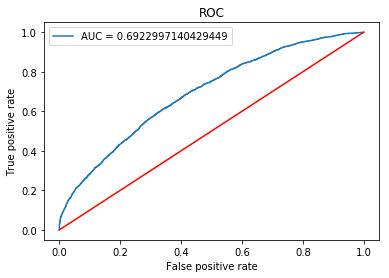

Test:
The model accuracy is 0.8786597611246169
The model f1 is 0.020477815699658702
The model p is 0.36363636363636365
The model recall is 0.010535557506584723
The model KS is 0.2559884955391835
The confusion matrix is:
 [[8301   21]
 [1127   12]]


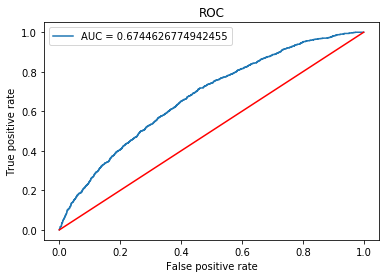

In [51]:
# 训练集
pre_train_cb = model_cb.predict(x_train)
pro_train_cb = model_cb.predict_proba(x_train)[:,1]
# 测试集
pre_test_cb = model_cb.predict(x_test)
pro_test_cb = model_cb.predict_proba(x_test)[:,1]

fpr, tpr, _ = model_performance(y_train, pre_train_cb, pro_train_cb, y_test, pre_test_cb, pro_test_cb)

(31534, 1)


C:\Users\15742\Anaconda35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    31534.000000
mean       611.818675
std         30.136858
min        455.397985
25%        591.188737
50%        611.418233
75%        634.373097
max        690.606631
Name: score, dtype: float64

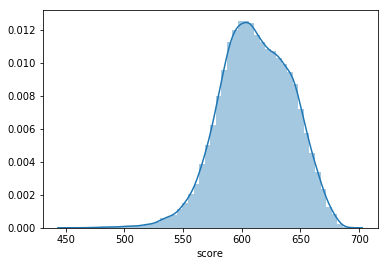

In [54]:
# 模型分数转换
all_pro_cb = pd.concat([pd.Series(pro_train_cb), pd.Series(pro_test_cb)], axis=0)
score_cat = get_model_score(all_pro_cb)
print(score_cat.shape)
# print('Max Score:%s' % max(score_cat.score))
# print('Min Score:%s' % min(score_cat.score))
# 分数整体分布图
sn.distplot(score_cat['score'])
score_cat['score'].describe()

<BarContainer object of 12 artists>

[Text(0,0,'emp_length'),
 Text(0,0,'purpose'),
 Text(0,0,'addr_state'),
 Text(0,0,'funded_amnt_inv'),
 Text(0,0,'int_rate'),
 Text(0,0,'annual_inc'),
 Text(0,0,'dti'),
 Text(0,0,'inq_last_6mths'),
 Text(0,0,'pub_rec'),
 Text(0,0,'revol_util'),
 Text(0,0,'pub_rec_bankruptcies'),
 Text(0,0,'pnt_loan_annual')]

Text(0.5,1,'CatBoost:Feature Importance')

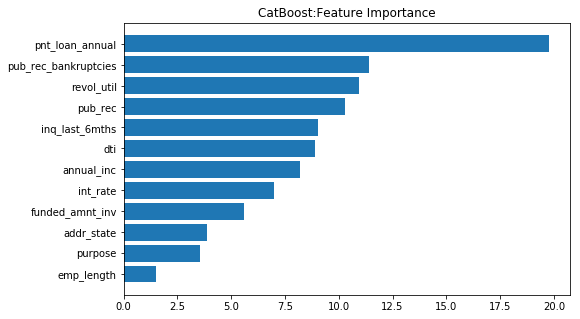

In [33]:
# 特征重要性
fimp_v = model_cb.get_feature_importance()
fimp_n = model_cb.feature_names_
fimp_vs = pd.Series(fimp_v).to_frame().rename(columns={0:'f_score'})
fimp_ns = pd.Series(fimp_n).to_frame().rename(columns={0:'f_name'})
fimp_result = pd.concat([fimp_ns, fimp_vs], axis=1)
fimp_result = fimp_result.sort_values(by='f_score')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.barh(range(len(fimp_result['f_score'])),fimp_result['f_score'])
ax.set_yticks(range(len(fimp_result['f_name'])))
ax.set_yticklabels(fimp_n)
plt.title('CatBoost:Feature Importance')
plt.show()

In [34]:
# ======== 4.2 lightGBM模型 ======== 

In [52]:
# 编码方式可自由选择，也可以使用内置的categorical_feature
# 训练集
x_train_code = x_train.copy()
for item in sub_char_feature:
    x_train_code[item] = x_train_code[item].astype("category").cat.codes +1
# 测试集
x_test_code = x_test.copy()
for item in sub_char_feature:
    x_test_code[item] = x_test_code[item].astype("category").cat.codes +1

C:\Users\15742\Anaconda35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\15742\Anaconda35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
# ?lgb.LGBMClassifier()

In [48]:
# 网格搜索策略--lightGBM
def get_params_init():
    params_init = {
        'boosting_type':'gbdt',
        'n_estimators': 100,
        'learning_rate':0.01,
        'max_depth':5,
        'subsample':0.7,
        'reg_alpha':0.0,
        'reg_lambda':0.0, 
    }
    return params_init

def get_tree_params():
    params = {
        'n_estimators':[10, 50, 100, 150, 200],
        'max_depth':[5, 6, 7, 8],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_al_params():
    params = {
        'reg_alpha':[0.1,0.5,1,2],
        'reg_lambda':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_al_params()]
    for _params_ in grid_params:
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model
        
def lgb_model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_lgb = lgb.LGBMClassifier(**params_init)
    print(model_lgb.get_params())
    model_lgb = grid_params_model(model_lgb, df, label)
    return model_lgb

In [49]:
# 模型训练与结果
model_lgb = lgb_model_run(x_train_code, y_train)
print(model_lgb.get_params())
model_lgb.fit(x_train_code, y_train)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.7, 'subsample_for_bin': 200000, 'subsample_freq': 0}


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000001E47F4EF158> {'max_depth': 8, 'n_estimators': 200} 0.8762288810612407
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000001E47F4EF158> {'subsample': 0.5} 0.8762288810612407
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000001E47F4EF158> {'learning_rate': 0.01} 0.8762288810612407
the other params!


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

<function _passthrough_scorer at 0x000001E47F4EF158> {'reg_alpha': 1, 'reg_lambda': 1} 0.8761835809433425
the other params!
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 1, 'reg_lambda': 1, 'silent': True, 'subsample': 0.5, 'subsample_for_bin': 200000, 'subsample_freq': 0}


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=8,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=1, reg_lambda=1, silent=True,
        subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train:
The model accuracy is 0.8762741811262629
The model f1 is 0.004374772147283996
The model p is 1.0
The model recall is 0.0021921812203142127
The confusion matrix is:
 [[19336     0]
 [ 2731     6]]


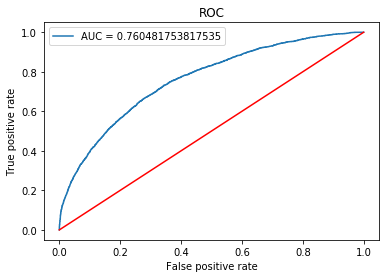

Test:
The model accuracy is 0.8797167318465279
The model f1 is 0.0017543859649122807
The model p is 1.0
The model recall is 0.000877963125548727
The model KS is 0.2908613132648813
The confusion matrix is:
 [[8322    0]
 [1138    1]]


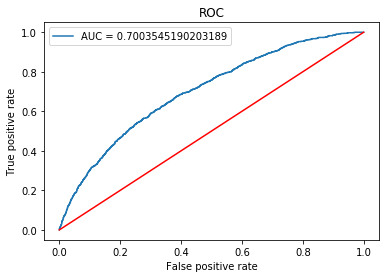

In [53]:
# 训练集
pre_train_lgb = model_lgb.predict(x_train_code)
pro_train_lgb = model_lgb.predict_proba(x_train_code)[:,1]
# 测试集
pre_test_lgb = model_lgb.predict(x_test_code)
pro_test_lgb = model_lgb.predict_proba(x_test_code)[:,1]

fpr, tpr, _ = model_performance(y_train, pre_train_lgb, pro_train_lgb, y_test, pre_test_lgb, pro_test_lgb)

(31534, 1)


C:\Users\15742\Anaconda35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    31534.000000
mean       620.878425
std         28.146752
min        503.161308
25%        602.791275
50%        620.931305
75%        640.625004
max        675.494371
Name: score, dtype: float64

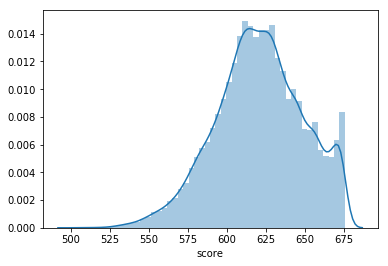

In [55]:
# 模型分数转换
all_pro_lgb = pd.concat([pd.Series(pro_train_lgb), pd.Series(pro_test_lgb)], axis=0)
score_lgb = get_model_score(all_pro_lgb)
print(score_lgb.shape)
# 分数整体分布图
sn.distplot(score_lgb['score'])
score_lgb['score'].describe()